In [ ]:
# !pip -q install --upgrade geopandas shapely pyogrio pyarrow fiona

# Import, Paths, Helpers

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

from pathlib import Path
import os, re, warnings
import numpy as np
import pandas as pd
from collections import defaultdict

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 200)
pd.set_option("display.width", 140)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Paths
PROJECT_ROOT = Path("/content/drive/MyDrive/t3_data")
RAW_DIR       = PROJECT_ROOT / "raw"
PROCESSED_DIR = PROJECT_ROOT / "processed"
OUT_DIR       = PROJECT_ROOT / "outputs"
OUT_VIZ_DIR   = OUT_DIR / "visualizations"
OUT_TAB_DIR   = OUT_DIR / "tables"
OUT_MOD_DIR   = OUT_DIR / "models"

for d in [PROCESSED_DIR, OUT_DIR, OUT_VIZ_DIR, OUT_TAB_DIR, OUT_MOD_DIR]:
    d.mkdir(parents=True, exist_ok=True)

In [ ]:
# Reproducibility
SEED = 42
np.random.seed(SEED)

def to_snake(s: str) -> str:
    s = s.strip()
    s = re.sub(r"[^\w]+", "_", s)
    s = re.sub(r"__+", "_", s)
    return s.lower().strip("_")

def standardize_columns(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df.columns = [to_snake(c) for c in df.columns]
    return df

def clean_id_series(s: pd.Series) -> pd.Series:
    return (s.astype("string")
              .str.strip()
              .str.replace(r"\s+", "", regex=True)
              .replace({"": pd.NA, "nan": pd.NA, "none": pd.NA, "None": pd.NA}))

def parse_date(df: pd.DataFrame, col: str) -> None:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce")

def print_missing(df: pd.DataFrame, cols) -> None:
    cols = [c for c in cols if c in df.columns]
    miss = df[cols].isna().mean().sort_values(ascending=False)
    display((miss * 100).round(2).rename("% missing").to_frame())

def save_geodata(gdf, base_path: Path):
    try:
        gdf.to_parquet(str(base_path.with_suffix(".parquet")), index=False)
        print(f"Saved GeoParquet: {base_path.with_suffix('.parquet')}")
    except Exception as e:
        print("GeoParquet save failed; will use GeoPackage. Reason:", repr(e))

    try:
        gdf.to_file(str(base_path.with_suffix(".gpkg")), driver="GPKG")
        print(f"Saved GeoPackage: {base_path.with_suffix('.gpkg')}")
    except Exception as e:
        print("GeoPackage save failed:", repr(e))

print("RAW_DIR:", RAW_DIR)
print("PROCESSED_DIR:", PROCESSED_DIR)
print("OUT_DIR:", OUT_DIR)

RAW_DIR: /content/drive/MyDrive/t3_data/raw
PROCESSED_DIR: /content/drive/MyDrive/t3_data/processed
OUT_DIR: /content/drive/MyDrive/t3_data/outputs


# Load & clean Parcels

In [ ]:
import geopandas as gpd

PARCELS_RAW = RAW_DIR / "parcels.geojson"
assert PARCELS_RAW.exists(), f"Missing: {PARCELS_RAW}"

parcels = gpd.read_file(PARCELS_RAW)
parcels = standardize_columns(parcels)

if parcels.crs is None:
    parcels = parcels.set_crs(epsg=4326)
else:
    parcels = parcels.to_crs(epsg=4326)

# Ensure SBL exists
if "sbl" not in parcels.columns:
    raise ValueError("Parcel file missing SBL column after standardization. Inspect columns: " + str(list(parcels.columns)[:30]))

parcels["sbl"] = clean_id_series(parcels["sbl"])

# Drop null geometries
parcels = parcels[~parcels.geometry.isna()].copy()

# Fix invalid geometries
try:
    parcels["geometry"] = parcels.geometry.make_valid()
except Exception:
    try:
        parcels["geometry"] = parcels.buffer(0)
    except Exception:
        pass

# Compute centroid lat/long
parcels_3857 = parcels.to_crs(epsg=3857)
centroids = parcels_3857.centroid.to_crs(epsg=4326)
parcels["centroid_lon"] = centroids.x
parcels["centroid_lat"] = centroids.y

# Parcel master - one row per SBL for joins
parcels_master = (parcels
                 .sort_values(["sbl"])
                 .drop_duplicates(subset=["sbl"], keep="first")
                 .copy())

# checks
print("PARCELS: raw rows:", len(parcels), " | master rows:", len(parcels_master))
print("Missing SBL (raw):", parcels["sbl"].isna().sum())
dup_sbl = parcels["sbl"].duplicated(keep=False).sum()
print("Duplicate SBL rows (raw):", dup_sbl)

tb = parcels.total_bounds
print("Parcel bounds (lon/lat):", tb)

# Quick check of key geo fields if present
key_cols = [c for c in ["nhood", "new_cc_dis", "ctid_2020", "zone_dist_", "total_av", "land_av", "yr_built", "n_resunits"] if c in parcels.columns]
print("Some useful columns found:", key_cols[:20])

print_missing(parcels_master, ["nhood", "new_cc_dis", "ctid_2020", "yr_built", "total_av", "n_resunits"])

# Save Progress
save_geodata(parcels_master, PROCESSED_DIR / "parcels_master")
# Also save a light (non-geometry) table for fast modeling
parcels_master.drop(columns="geometry").to_parquet(PROCESSED_DIR / "parcels_master_attr.parquet", index=False)
print("Saved:", PROCESSED_DIR / "parcels_master_attr.parquet")

PARCELS: raw rows: 41096  | master rows: 40891
Missing SBL (raw): 206
Duplicate SBL rows (raw): 206
Parcel bounds (lon/lat): [-76.204338    42.98417473 -76.07428305  43.0860716 ]
Some useful columns found: ['nhood', 'new_cc_dis', 'ctid_2020', 'total_av', 'land_av', 'yr_built', 'n_resunits']


% missing
nhood             0.0
new_cc_dis        0.0
ctid_2020         0.0
yr_built          0.0
total_av          0.0
n_resunits        0.0

Saved GeoParquet: /content/drive/MyDrive/t3_data/processed/parcels_master.parquet
Saved GeoPackage: /content/drive/MyDrive/t3_data/processed/parcels_master.gpkg
Saved: /content/drive/MyDrive/t3_data/processed/parcels_master_attr.parquet


# Load & Clean Code Violations

In [ ]:
CODE_RAW = RAW_DIR / "code_violations.geojson"
assert CODE_RAW.exists(), f"Missing: {CODE_RAW}"

code = gpd.read_file(CODE_RAW)
code = standardize_columns(code)

if code.crs is None:
    code = code.set_crs(epsg=4326)
else:
    code = code.to_crs(epsg=4326)

if "sbl" not in code.columns:
    raise ValueError("Code file missing SBL column after standardization. Inspect columns: " + str(list(code.columns)[:30]))
code["sbl"] = clean_id_series(code["sbl"])

# Parse dates
for dc in ["open_date", "violation_date", "comply_by_date", "status_date"]:
    parse_date(code, dc)

# Fix placeholder comply-by dates
if "comply_by_date" in code.columns:
    bad = code["comply_by_date"].notna() & (code["comply_by_date"].dt.year <= 1901) # e.g. 1901-01-01
    if bad.any():
        code.loc[bad, "comply_by_date"] = pd.NaT
        print(f"Set comply_by_date to NaT for {bad.sum()} placeholder rows")

if "status" in code.columns:
    code["status"] = code["status"].astype("string").str.strip().str.lower()

# Extract lat/long from geometry (for fast plotting & feature engineering)
code = code[~code.geometry.isna()].copy()
code["lon"] = code.geometry.x
code["lat"] = code.geometry.y

# Filter obviously broken coordinates using parcel bounds (if parcels loaded)
minx, miny, maxx, maxy = parcels.total_bounds
coord_ok = code["lon"].between(minx - 0.05, maxx + 0.05) & code["lat"].between(miny - 0.05, maxy + 0.05)
print("Code rows with plausible coords:", coord_ok.mean().round(4) * 100, "%")
code = code[coord_ok].copy()

# checks
print("CODE rows:", len(code))
print("Missing SBL:", code["sbl"].isna().sum())
if "complaint_number" in code.columns:
    print("Unique complaint_number:", code["complaint_number"].nunique(dropna=True))
if "violation_date" in code.columns:
    print("violation_date range:", code["violation_date"].min(), "->", code["violation_date"].max())
if "open_date" in code.columns:
    print("open_date range:", code["open_date"].min(), "->", code["open_date"].max())

parcel_sbl_set = set(parcels_master["sbl"].dropna().tolist())
match_rate = code["sbl"].isin(parcel_sbl_set).mean()
print("SBL match rate to parcel master:", round(match_rate * 100, 2), "%")

print_missing(code, ["violation_date", "open_date", "comply_by_date", "status", "complaint_number", "lat", "lon"])

# Save Progress
save_geodata(code, PROCESSED_DIR / "code_violations_clean")
# Save a light table for modeling (no geometry)
keep_cols = [c for c in code.columns if c != "geometry"]
code[keep_cols].to_parquet(PROCESSED_DIR / "code_violations_clean.parquet", index=False)
print("Saved:", PROCESSED_DIR / "code_violations_clean.parquet")

Set comply_by_date to NaT for 291 placeholder rows
Code rows with plausible coords: 100.0 %
CODE rows: 140669
Missing SBL: 0
Unique complaint_number: 58476
violation_date range: 2017-01-03 08:15:59+00:00 -> 2026-02-19 16:41:18.820000+00:00
open_date range: 2012-08-27 12:05:30+00:00 -> 2026-02-19 15:44:59.380000+00:00
SBL match rate to parcel master: 99.47 %


% missing
comply_by_date         0.21
violation_date         0.00
open_date              0.00
complaint_number       0.00
lat                    0.00
lon                    0.00

Saved GeoParquet: /content/drive/MyDrive/t3_data/processed/code_violations_clean.parquet
Saved GeoPackage: /content/drive/MyDrive/t3_data/processed/code_violations_clean.gpkg
Saved: /content/drive/MyDrive/t3_data/processed/code_violations_clean.parquet


# Load processed + enforce consistent types + SBL join

In [ ]:
PARCELS_GPKG = PROCESSED_DIR / "parcels_master.gpkg"
CODE_GPKG    = PROCESSED_DIR / "code_violations_clean.gpkg"

parcels = gpd.read_file(PARCELS_GPKG)
code    = gpd.read_file(CODE_GPKG)

parcels = standardize_columns(parcels)
code    = standardize_columns(code)

parcels["sbl"] = clean_id_series(parcels["sbl"])
code["sbl"]    = clean_id_series(code["sbl"])

parcels = parcels.to_crs(epsg=4326)
code    = code.to_crs(epsg=4326)

for dc in ["open_date", "violation_date", "comply_by_date", "status_date"]:
    parse_date(code, dc)

# Choose an "event date" for time series
# Priority: violation_date -> open_date
code["event_dt"] = code["violation_date"].fillna(code["open_date"])
code = code[~code["event_dt"].isna()].copy()

# Normalize to naive datetime (drop tz) for easier grouping
code["event_dt"] = code["event_dt"].dt.tz_convert(None) if getattr(code["event_dt"].dt, "tz", None) is not None else code["event_dt"]
if "open_date" in code.columns:
    code["open_date"] = code["open_date"].dt.tz_convert(None) if getattr(code["open_date"].dt, "tz", None) is not None else code["open_date"]
if "violation_date" in code.columns:
    code["violation_date"] = code["violation_date"].dt.tz_convert(None) if getattr(code["violation_date"].dt, "tz", None) is not None else code["violation_date"]
if "comply_by_date" in code.columns:
    code["comply_by_date"] = code["comply_by_date"].dt.tz_convert(None) if getattr(code["comply_by_date"].dt, "tz", None) is not None else code["comply_by_date"]

# Keep analysis window (2017+++++++)
code = code[code["event_dt"] >= pd.Timestamp("2017-01-01")].copy()

# Join parcel attributes to each code record
parcel_attr_cols = [c for c in parcels.columns if c != "geometry"]
code_join = code.merge(parcels[parcel_attr_cols], on="sbl", how="left", validate="m:1")

match_rate = code_join["nhood"].notna().mean() if "nhood" in code_join.columns else code_join.filter(like="nhood").notna().mean().iloc[0]
print("Rows after 2017 filter:", len(code_join))
print("Parcel attribute match rate (using nhood proxy):", round(match_rate*100, 2), "%")

# Save integrated fact table
save_geodata(code_join, PROCESSED_DIR / "code_with_parcel_attr")

Rows after 2017 filter: 140669
Parcel attribute match rate (using nhood proxy): 99.47 %
Saved GeoParquet: /content/drive/MyDrive/t3_data/processed/code_with_parcel_attr.parquet
Saved GeoPackage: /content/drive/MyDrive/t3_data/processed/code_with_parcel_attr.gpkg


compliance-debt fields

In [ ]:
# Status normalization
if "status" in code_join.columns:
    code_join["status"] = code_join["status"].astype("string").str.strip().str.lower()

ASOF_DATE = code_join["event_dt"].max()  # dataset latest date
print("ASOF_DATE:", ASOF_DATE)

# Overdue only meaningful for open rows and valid comply_by_date
code_join["is_open"] = (code_join["status"] == "open") if "status" in code_join.columns else False
code_join["has_comply_by"] = code_join["comply_by_date"].notna() if "comply_by_date" in code_join.columns else False

code_join["days_overdue"] = np.nan
mask = code_join["is_open"] & code_join["has_comply_by"]
code_join.loc[mask, "days_overdue"] = (ASOF_DATE - code_join.loc[mask, "comply_by_date"]).dt.days
code_join.loc[mask & (code_join["days_overdue"] < 0), "days_overdue"] = 0

# Sanity stats
tmp = code_join.loc[mask, "days_overdue"].dropna()
print("Open w/ comply_by rows:", mask.sum())
print("Overdue share (open w/ comply_by):", round((tmp > 0).mean()*100, 2), "%")
print("Median overdue days:", int(tmp.median()) if len(tmp) else None)
print("95th pct overdue days:", int(tmp.quantile(0.95)) if len(tmp) else None)

# Save a light table for faster groupbys (no geometry)
light_cols = [c for c in code_join.columns if c != "geometry"]
code_join[light_cols].to_parquet(PROCESSED_DIR / "code_with_parcel_attr.parquet", index=False)
print("Saved:", PROCESSED_DIR / "code_with_parcel_attr.parquet")

ASOF_DATE: 2026-02-19 16:41:18.820000
Open w/ comply_by rows: 0
Overdue share (open w/ comply_by): nan %
Median overdue days: None
95th pct overdue days: None
Saved: /content/drive/MyDrive/t3_data/processed/code_with_parcel_attr.parquet


In [ ]:
# Fix Rowss
# Detect status column after merge
status_candidates = [c for c in code_join.columns if c.startswith("status")]
print("Status-like columns:", status_candidates)

# Choose the best candidate
status_col = None
if "status" in code_join.columns:
    status_col = "status"
elif "status_x" in code_join.columns:
    status_col = "status_x"
elif "current_status" in code_join.columns:
    status_col = "current_status"
else:
    # last resort: pick a status-like column with low cardinality
    for c in status_candidates:
        if code_join[c].nunique(dropna=True) <= 10:
            status_col = c
            break

print("Using status column:", status_col)
if status_col is None:
    raise ValueError("Could not find a usable status column. Inspect code_join columns manually.")

# Normalize status
code_join[status_col] = code_join[status_col].astype("string").str.strip().str.lower()

# Recompute ASOF_DATE
ASOF_DATE = pd.to_datetime(code_join["event_dt"]).max()
print("ASOF_DATE:", ASOF_DATE)

# Compute overdue only for currently-open rows with comply_by_date
code_join["is_open"] = code_join[status_col].str.contains("open", na=False)

if "comply_by_date" not in code_join.columns:
    raise ValueError("comply_by_date missing in code_join")

code_join["has_comply_by"] = code_join["comply_by_date"].notna()

code_join["days_overdue"] = np.nan
mask = code_join["is_open"] & code_join["has_comply_by"]
code_join.loc[mask, "days_overdue"] = (ASOF_DATE - code_join.loc[mask, "comply_by_date"]).dt.days
code_join.loc[mask & (code_join["days_overdue"] < 0), "days_overdue"] = 0

# Sanity stats
print("Open rows:", int(code_join["is_open"].sum()))
print("Open w/ comply_by rows:", int(mask.sum()))
tmp = code_join.loc[mask, "days_overdue"].dropna()
print("Overdue share (open w/ comply_by):", round((tmp > 0).mean() * 100, 2), "%")
print("Median overdue days:", int(tmp.median()) if len(tmp) else None)
print("95th pct overdue days:", int(tmp.quantile(0.95)) if len(tmp) else None)

# Save light table update
light_cols = [c for c in code_join.columns if c != "geometry"]
code_join[light_cols].to_parquet(PROCESSED_DIR / "code_with_parcel_attr.parquet", index=False)
print("Updated:", PROCESSED_DIR / "code_with_parcel_attr.parquet")

Status-like columns: ['status_type_name', 'status_date']
Using status column: status_type_name
ASOF_DATE: 2026-02-19 16:41:18.820000
Open rows: 17985
Open w/ comply_by rows: 17969
Overdue share (open w/ comply_by): 93.9 %
Median overdue days: 367
95th pct overdue days: 1848
Updated: /content/drive/MyDrive/t3_data/processed/code_with_parcel_attr.parquet


In [ ]:
panel = pd.read_parquet(PROCESSED_DIR / "panel_parcel_month_codefeat.parquet")
print("y_next_1m positive rate:", round(panel["y_next_1m"].astype(float).mean()*100, 3), "%")
print("y_next_3m positive rate:", round(panel["y_next_3m"].astype(float).mean()*100, 3), "%")

y_next_1m positive rate: 2.856 %
y_next_3m positive rate: 7.932 %


In [ ]:
# Parcel centroids as points for spatial exposure features
parcels_pts = parcels.copy()
parcels_pts["geometry"] = parcels_pts.geometry.to_crs(epsg=3857).centroid.to_crs(epsg=4326)

# Keep only essential fields to keep it light
keep = [c for c in ["sbl", "nhood", "new_cc_dis", "ctid_2020", "total_av", "land_av", "yr_built", "n_resunits", "geometry"] if c in parcels_pts.columns]
parcels_pts = parcels_pts[keep].copy()

save_geodata(parcels_pts, PROCESSED_DIR / "parcels_centroids")

Saved GeoParquet: /content/drive/MyDrive/t3_data/processed/parcels_centroids.parquet
Saved GeoPackage: /content/drive/MyDrive/t3_data/processed/parcels_centroids.gpkg


In [ ]:
code_df = pd.read_parquet(PROCESSED_DIR / "code_with_parcel_attr.parquet")

# Use complaint_number to avoid double-counting multi-violation cases
if "complaint_number" not in code_df.columns:
    raise ValueError("complaint_number missing in integrated table.")

code_df["event_month"] = code_df["event_dt"].dt.to_period("M").dt.to_timestamp()

# Case-level events per parcel-month
cases = (code_df.dropna(subset=["complaint_number", "sbl"])
               .drop_duplicates(subset=["complaint_number"])  # one row per case
               .groupby(["sbl", "event_month"])
               .size()
               .rename("new_cases")
               .reset_index())

# Build full month range
min_m = cases["event_month"].min()
max_m = cases["event_month"].max()
months = pd.date_range(min_m, max_m, freq="MS")

# Parcel universe: parcels with any activity + optionally all parcels
active_sbl = cases["sbl"].unique()
panel = (pd.MultiIndex.from_product([active_sbl, months], names=["sbl", "month"])
         .to_frame(index=False))

panel = panel.merge(cases, left_on=["sbl", "month"], right_on=["sbl", "event_month"], how="left")
panel["new_cases"] = panel["new_cases"].fillna(0).astype(int)
panel = panel.drop(columns=["event_month"])

print("Panel rows:", len(panel), " | parcels:", panel["sbl"].nunique(), " | months:", panel["month"].nunique())
print("Avg new_cases per parcel-month:", round(panel["new_cases"].mean(), 4))

# Target for prediction (next-month cases)
panel = panel.sort_values(["sbl", "month"])
panel["y_next_1m"] = (panel.groupby("sbl")["new_cases"].shift(-1) > 0).astype("Int64")
panel["y_next_3m"] = (panel.groupby("sbl")["new_cases"]
                      .shift(-1).rolling(3, min_periods=3).sum().reset_index(level=0, drop=True) > 0).astype("Int64")

# Drop last months where labels are missing
panel = panel.dropna(subset=["y_next_1m"]).copy()

# Save base panel
panel.to_parquet(PROCESSED_DIR / "panel_parcel_month_base.parquet", index=False)
print("Saved:", PROCESSED_DIR / "panel_parcel_month_base.parquet")

Panel rows: 1934790  | parcels: 17589  | months: 110
Avg new_cases per parcel-month: 0.0302
Saved: /content/drive/MyDrive/t3_data/processed/panel_parcel_month_base.parquet


In [ ]:
panel = pd.read_parquet(PROCESSED_DIR / "panel_parcel_month_base.parquet")
code_df = pd.read_parquet(PROCESSED_DIR / "code_with_parcel_attr.parquet")

# monthly case counts (same as new_cases) but as series for rolling windows
monthly = (code_df.dropna(subset=["complaint_number", "sbl"])
                  .drop_duplicates(subset=["complaint_number"])
                  .assign(month=lambda d: d["event_dt"].dt.to_period("M").dt.to_timestamp())
                  .groupby(["sbl", "month"]).size().rename("cases").reset_index())

panel = panel.merge(monthly, on=["sbl", "month"], how="left")
panel["cases"] = panel["cases"].fillna(0).astype(int)

# Rolling windows per parcel
panel = panel.sort_values(["sbl", "month"])
g = panel.groupby("sbl", group_keys=False)

for w in [3, 6, 12]:
    panel[f"cases_roll_{w}m"] = g["cases"].rolling(w, min_periods=1).sum().reset_index(level=0, drop=True)
    panel[f"cases_mean_{w}m"] = g["cases"].rolling(w, min_periods=1).mean().reset_index(level=0, drop=True)

# Recency: months since last case
panel["last_case_month"] = g.apply(lambda d: d["month"].where(d["cases"] > 0).ffill()).reset_index(level=0, drop=True)
panel["months_since_case"] = ((panel["month"].dt.to_period("M").astype(int) -
                              panel["last_case_month"].dt.to_period("M").astype(int)).astype("float"))
panel["months_since_case"] = panel["months_since_case"].fillna(999.0)

# Overdue burden per parcel-month (open + comply_by)
if "days_overdue" in code_df.columns:
    overdue_monthly = (code_df[code_df["days_overdue"].notna()]
                       .assign(month=lambda d: d["event_dt"].dt.to_period("M").dt.to_timestamp())
                       .groupby(["sbl", "month"])["days_overdue"]
                       .agg(overdue_sum="sum", overdue_med="median", overdue_max="max")
                       .reset_index())
    panel = panel.merge(overdue_monthly, on=["sbl", "month"], how="left")
    for c in ["overdue_sum", "overdue_med", "overdue_max"]:
        panel[c] = panel[c].fillna(0)

# Save features v1 (code-only)
panel.to_parquet(PROCESSED_DIR / "panel_parcel_month_codefeat.parquet", index=False)
print("Saved:", PROCESSED_DIR / "panel_parcel_month_codefeat.parquet")

# check
print(panel[["cases_roll_3m", "cases_roll_6m", "months_since_case", "y_next_1m"]].corr(numeric_only=True))

Saved: /content/drive/MyDrive/t3_data/processed/panel_parcel_month_codefeat.parquet
                   cases_roll_3m  cases_roll_6m  months_since_case  y_next_1m
cases_roll_3m           1.000000       0.758535           0.241663   0.070455
cases_roll_6m           0.758535       1.000000           0.317839   0.081915
months_since_case       0.241663       0.317839           1.000000   0.044501
y_next_1m               0.070455       0.081915           0.044501   1.000000


# Load + clean Crime and Parking

In [ ]:
def find_col(cols, options):
    cols_l = {c.lower(): c for c in cols}
    for o in options:
        if o in cols_l:
            return cols_l[o]
    return None

def load_crime_csv(path, year, part):
    df = pd.read_csv(path)
    df = standardize_columns(df)

    # lat/lon
    lat_c = find_col(df.columns, ["lat", "latitude", "y"])
    lon_c = find_col(df.columns, ["lon", "long", "longitude", "x"])
    if lat_c is None or lon_c is None:
        raise ValueError(f"Missing lat/lon in {path.name}. Found lat={lat_c}, lon={lon_c}")

    df["lat"] = pd.to_numeric(df[lat_c], errors="coerce")
    df["lon"] = pd.to_numeric(df[lon_c], errors="coerce")

    # date column (prefer DATEEND, then DATESTART, then other common variants)
    dt_c = find_col(df.columns, [
        "dateend", "date_end",
        "datestart", "date_start",
        "occurred_date", "incident_date", "report_date",
        "date"
    ])
    if dt_c is None:
        raise ValueError(f"Missing crime date column in {path.name}. Inspect columns: {list(df.columns)[:30]}")

    # Force UTC-aware parsing to avoid dtype mixing across files
    df["event_dt"] = pd.to_datetime(df[dt_c], errors="coerce", utc=True)

    df["year"] = year
    df["part"] = part

    # keep valid rows
    df = df.dropna(subset=["event_dt", "lat", "lon"]).copy()

    # Hard filter to the file's year (avoids stray bad dates)
    start = pd.Timestamp(f"{year}-01-01", tz="UTC")
    end   = pd.Timestamp(f"{year+1}-01-01", tz="UTC")
    df = df[(df["event_dt"] >= start) & (df["event_dt"] < end)].copy()

    # Convert to tz-naive for downstream grouping
    df["event_dt"] = df["event_dt"].dt.tz_convert(None)

    return df

# Paths (match your filenames in Drive raw/)
crime_files = [
    (RAW_DIR / "crime_2023_p1.csv", 2023, "p1"),
    (RAW_DIR / "crime_2023_p2.csv", 2023, "p2"),
    (RAW_DIR / "crime_2024_p1.csv", 2024, "p1"),
    (RAW_DIR / "crime_2024_p2.csv", 2024, "p2"),
    (RAW_DIR / "crime_2025_p1.csv", 2025, "p1"),
]

crime_dfs = []
for p, y, part in crime_files:
    assert p.exists(), f"Missing: {p}"
    df = load_crime_csv(p, y, part)
    crime_dfs.append(df)
    print(p.name, "rows:", len(df), "date range:", df["event_dt"].min(), "->", df["event_dt"].max())

crime = pd.concat(crime_dfs, ignore_index=True)
print("CRIME total rows:", len(crime))
print("CRIME years:", crime["year"].value_counts().to_dict())
print("CRIME parts:", crime["part"].value_counts().to_dict())

crime_keep = [
    "event_dt", "lat", "lon", "year", "part",
    # common crime type fields (keep only those that exist)
    "code_defined", "description", "ucr", "ucr_description", "offense", "offense_description",
    "address", "location"
]
crime_keep = [c for c in crime_keep if c in crime.columns]

crime_slim = crime[crime_keep].copy()

# Ensure all remaining object columns are safe for parquet
for c in crime_slim.select_dtypes(include=["object"]).columns:
    crime_slim[c] = crime_slim[c].astype("string")

crime_slim.to_parquet(PROCESSED_DIR / "crime_clean.parquet", index=False, engine="pyarrow")
print("Saved:", PROCESSED_DIR / "crime_clean.parquet")
print("crime_clean columns:", list(crime_slim.columns))

# crime.to_parquet(PROCESSED_DIR / "crime_clean.parquet", index=False)
# print("Saved:", PROCESSED_DIR / "crime_clean.parquet")


# ===== Parking =====
parking_path = RAW_DIR / "parking_2023_present.csv"
assert parking_path.exists(), f"Missing: {parking_path}"

parking = pd.read_csv(parking_path)
parking = standardize_columns(parking)

lat_c = find_col(parking.columns, ["lat", "latitude"])
lon_c = find_col(parking.columns, ["lon", "long", "longitude"])
dt_c  = find_col(parking.columns, ["issued_date", "issue_date", "issue_dt", "date"])

if dt_c is None:
    raise ValueError("Parking missing issued_date-like column; inspect columns.")

parking["lat"] = pd.to_numeric(parking[lat_c], errors="coerce") if lat_c else np.nan
parking["lon"] = pd.to_numeric(parking[lon_c], errors="coerce") if lon_c else np.nan

# Force UTC parse; convert to tz-naive
parking["event_dt"] = pd.to_datetime(parking[dt_c], errors="coerce", utc=True).dt.tz_convert(None)

print("PARKING rows:", len(parking), "date range:", parking["event_dt"].min(), "->", parking["event_dt"].max())
print("PARKING coord missing %:", round(parking[["lat","lon"]].isna().any(axis=1).mean()*100, 2))

for c in parking.select_dtypes(include=["object"]).columns:
    parking[c] = parking[c].astype("string")

parking.to_parquet(PROCESSED_DIR / "parking_clean.parquet", index=False)
print("Saved:", PROCESSED_DIR / "parking_clean.parquet")

crime_2023_p1.csv rows: 6502 date range: 2023-01-01 00:00:00 -> 2023-12-26 00:00:00
crime_2023_p2.csv rows: 6632 date range: 2023-01-01 05:00:00 -> 2023-12-31 05:00:00
crime_2024_p1.csv rows: 6993 date range: 2024-01-01 00:00:00 -> 2024-12-31 00:00:00
crime_2024_p2.csv rows: 6579 date range: 2024-01-01 00:00:00 -> 2024-12-31 00:00:00
crime_2025_p1.csv rows: 33 date range: 2025-01-01 00:00:00 -> 2025-01-05 00:00:00
CRIME total rows: 26739
CRIME years: {2024: 13572, 2023: 13134, 2025: 33}
CRIME parts: {'p1': 13528, 'p2': 13211}
Saved: /content/drive/MyDrive/t3_data/processed/crime_clean.parquet
crime_clean columns: ['event_dt', 'lat', 'lon', 'year', 'part', 'code_defined', 'address']
PARKING rows: 123832 date range: 2023-01-01 01:01:00 -> 2210-02-08 22:10:00
PARKING coord missing %: 21.9
Saved: /content/drive/MyDrive/t3_data/processed/parking_clean.parquet


In [ ]:
parking = pd.read_parquet(PROCESSED_DIR / "parking_clean.parquet")

# Use code ASOF as a sensible max date cap (+30 days buffer)
code_df = pd.read_parquet(PROCESSED_DIR / "code_with_parcel_attr.parquet", columns=["event_dt"])
ASOF_CODE = pd.to_datetime(code_df["event_dt"]).max()
MAX_DATE = ASOF_CODE + pd.Timedelta(days=30)
MIN_DATE = pd.Timestamp("2023-01-01")

print("ASOF_CODE:", ASOF_CODE)
print("Parking date range before:", parking["event_dt"].min(), "->", parking["event_dt"].max())

bad_future = (parking["event_dt"] > MAX_DATE).sum()
bad_past   = (parking["event_dt"] < MIN_DATE).sum()
print("Rows > MAX_DATE:", int(bad_future))
print("Rows < MIN_DATE:", int(bad_past))

parking = parking[(parking["event_dt"] >= MIN_DATE) & (parking["event_dt"] <= MAX_DATE)].copy()

# Coordinate plausibility filter using parcel bounds
parcels = gpd.read_file(PROCESSED_DIR / "parcels_master.gpkg").to_crs(epsg=4326)
minx, miny, maxx, maxy = parcels.total_bounds

# Keep only rows with coords and within bounds (+ small margin)
parking = parking.dropna(subset=["lat", "lon"]).copy()
coord_ok = parking["lon"].between(minx - 0.05, maxx + 0.05) & parking["lat"].between(miny - 0.05, maxy + 0.05)
print("Parking coord-ok %:", round(coord_ok.mean()*100, 2))
parking = parking[coord_ok].copy()

# Create month bucket for aggregation
parking["month"] = parking["event_dt"].dt.to_period("M").dt.to_timestamp()

# Slim columns for features
keep_cols = [c for c in ["event_dt", "month", "lat", "lon", "description", "status", "amount"] if c in parking.columns]
parking_slim = parking[keep_cols].copy()

# Parquet-safe strings
for c in parking_slim.select_dtypes(include=["object"]).columns:
    parking_slim[c] = parking_slim[c].astype("string")

parking_slim.to_parquet(PROCESSED_DIR / "parking_slim.parquet", index=False, engine="pyarrow")
print("Saved:", PROCESSED_DIR / "parking_slim.parquet")
print("Parking rows after filters:", len(parking_slim))
print("Parking date range after:", parking_slim["event_dt"].min(), "->", parking_slim["event_dt"].max())

ASOF_CODE: 2026-02-19 16:41:18.820000
Parking date range before: 2023-01-01 01:01:00 -> 2210-02-08 22:10:00
Rows > MAX_DATE: 4
Rows < MIN_DATE: 0
Parking coord-ok %: 99.99
Saved: /content/drive/MyDrive/t3_data/processed/parking_slim.parquet
Parking rows after filters: 96693
Parking date range after: 2023-01-01 01:01:00 -> 2025-10-25 09:45:00


## dissolve parcels to neighborhood polygons

In [ ]:
parcels = gpd.read_file(PROCESSED_DIR / "parcels_master.gpkg").to_crs(epsg=4326)
parcels = standardize_columns(parcels)

assert "nhood" in parcels.columns, "Parcel file missing nhood"

nhood_poly = (parcels[["nhood", "geometry"]]
              .dropna(subset=["nhood"])
              .dissolve(by="nhood")
              .reset_index())

# Fix invalid geometries (rare but possible)
try:
    nhood_poly["geometry"] = nhood_poly.geometry.make_valid()
except Exception:
    pass

print("Neighborhood polygons:", len(nhood_poly))
save_geodata(nhood_poly, PROCESSED_DIR / "nhood_polygons")

Neighborhood polygons: 33
Saved GeoParquet: /content/drive/MyDrive/t3_data/processed/nhood_polygons.parquet
Saved GeoPackage: /content/drive/MyDrive/t3_data/processed/nhood_polygons.gpkg


# Spatially join crime + parking to neighborhoods and build nhood-month features

In [ ]:
nhood_poly = gpd.read_file(PROCESSED_DIR / "nhood_polygons.gpkg").to_crs(epsg=4326)

# ---- Crime ----
crime = pd.read_parquet(PROCESSED_DIR / "crime_clean.parquet")
crime["month"] = pd.to_datetime(crime["event_dt"]).dt.to_period("M").dt.to_timestamp()

crime_gdf = gpd.GeoDataFrame(
    crime,
    geometry=gpd.points_from_xy(crime["lon"], crime["lat"]),
    crs="EPSG:4326"
)

crime_join = gpd.sjoin(crime_gdf, nhood_poly[["nhood", "geometry"]], how="inner", predicate="within")

crime_counts = (crime_join
                .groupby(["nhood", "month", "part"])
                .size()
                .rename("cnt")
                .reset_index())

crime_pivot = (crime_counts
               .pivot_table(index=["nhood", "month"], columns="part", values="cnt", fill_value=0)
               .reset_index())

# Standardize column names
crime_pivot.columns = [to_snake(str(c)) for c in crime_pivot.columns]
# expected: nhood, month, p1, p2
crime_pivot = crime_pivot.rename(columns={"p1": "crime_p1", "p2": "crime_p2"})

# ---- Parking ----
parking = pd.read_parquet(PROCESSED_DIR / "parking_slim.parquet")

parking_gdf = gpd.GeoDataFrame(
    parking,
    geometry=gpd.points_from_xy(parking["lon"], parking["lat"]),
    crs="EPSG:4326"
)

parking_join = gpd.sjoin(parking_gdf, nhood_poly[["nhood", "geometry"]], how="inner", predicate="within")

parking_counts = (parking_join
                  .groupby(["nhood", "month"])
                  .size()
                  .rename("parking_cnt")
                  .reset_index())

# ---- Combine ----
nhood_month = parking_counts.merge(crime_pivot, on=["nhood", "month"], how="outer")
for c in ["parking_cnt", "crime_p1", "crime_p2"]:
    if c in nhood_month.columns:
        nhood_month[c] = nhood_month[c].fillna(0).astype(int)

# Rolling context features (3m and 6m) computed per neighborhood
nhood_month = nhood_month.sort_values(["nhood", "month"])
g = nhood_month.groupby("nhood", group_keys=False)

for w in [3, 6]:
    for c in ["parking_cnt", "crime_p1", "crime_p2"]:
        if c in nhood_month.columns:
            nhood_month[f"{c}_roll_{w}m"] = g[c].rolling(w, min_periods=1).sum().reset_index(level=0, drop=True)

nhood_month.to_parquet(PROCESSED_DIR / "nhood_month_features.parquet", index=False)
print("Saved:", PROCESSED_DIR / "nhood_month_features.parquet")
print("nhood_month rows:", len(nhood_month), "nhoods:", nhood_month["nhood"].nunique(), "months:", nhood_month["month"].nunique())

Saved: /content/drive/MyDrive/t3_data/processed/nhood_month_features.parquet
nhood_month rows: 760 nhoods: 32 months: 28


# Merge neighborhood features into the parcel-month panel

In [ ]:
panel = pd.read_parquet(PROCESSED_DIR / "panel_parcel_month_codefeat.parquet")
parc_attr = pd.read_parquet(PROCESSED_DIR / "parcels_master_attr.parquet")
nhood_month = pd.read_parquet(PROCESSED_DIR / "nhood_month_features.parquet")

# Merge parcel static attrs (adds nhood, values, year built, etc.)
panel = panel.merge(parc_attr, on="sbl", how="left", validate="m:1")

# Merge neighborhood-month features
panel = panel.merge(nhood_month, on=["nhood", "month"], how="left")

# Fill missing neighborhood context with 0 (e.g., months with no events)
ctx_cols = [c for c in panel.columns if c.startswith(("parking_", "crime_"))]
for c in ctx_cols:
    panel[c] = panel[c].fillna(0)

# Save final feature table v2
panel.to_parquet(PROCESSED_DIR / "panel_parcel_month_fullfeatures.parquet", index=False)
print("Saved:", PROCESSED_DIR / "panel_parcel_month_fullfeatures.parquet")

# Sanity: check a few columns
print(panel[["y_next_1m", "cases_roll_6m"] + ctx_cols[:6]].head())

Saved: /content/drive/MyDrive/t3_data/processed/panel_parcel_month_fullfeatures.parquet
   y_next_1m  cases_roll_6m  parking_cnt  crime_p1  crime_p2  parking_cnt_roll_3m  crime_p1_roll_3m  crime_p2_roll_3m
0          1            0.0          0.0       0.0       0.0                  0.0               0.0               0.0
1          0            1.0          0.0       0.0       0.0                  0.0               0.0               0.0
2          0            1.0          0.0       0.0       0.0                  0.0               0.0               0.0
3          0            1.0          0.0       0.0       0.0                  0.0               0.0               0.0
4          0            1.0          0.0       0.0       0.0                  0.0               0.0               0.0


# Load integrated tables + define ASOF

In [ ]:
code = pd.read_parquet(PROCESSED_DIR / "code_with_parcel_attr.parquet")
panel = pd.read_parquet(PROCESSED_DIR / "panel_parcel_month_fullfeatures.parquet")
nhood_poly = gpd.read_file(PROCESSED_DIR / "nhood_polygons.gpkg").to_crs(epsg=4326)
crime = pd.read_parquet(PROCESSED_DIR / "crime_clean.parquet")
parking = pd.read_parquet(PROCESSED_DIR / "parking_slim.parquet")

ASOF = pd.to_datetime(code["event_dt"]).max()
print("ASOF:", ASOF)

ASOF: 2026-02-19 16:41:18.820000


# Best Insight: “Compliance Debt” (overdue burden) summary tables

In [ ]:
need = ["nhood", "days_overdue", "is_open", "has_comply_by"]
missing = [c for c in need if c not in code.columns]
if missing:
    raise ValueError("Missing expected columns in code_with_parcel_attr: " + str(missing))

open_mask = code["is_open"] & code["has_comply_by"]
overdue = code.loc[open_mask].copy()
overdue["is_overdue"] = overdue["days_overdue"] > 0

# Citywide snapshot stats
city_stats = {
    "asof": ASOF,
    "open_rows": int(code["is_open"].sum()),
    "open_w_comply_by": int(open_mask.sum()),
    "overdue_share_open_w_comply_by": float(overdue["is_overdue"].mean()),
    "median_overdue_days": float(overdue["days_overdue"].median()),
    "p95_overdue_days": float(overdue["days_overdue"].quantile(0.95)),
}
city_stats_df = pd.DataFrame([city_stats])
display(city_stats_df)

# Neighborhood burden table
nhood_burden = (overdue.groupby("nhood")
                .agg(open_overdue_rows=("days_overdue", "size"),
                     overdue_share=("is_overdue", "mean"),
                     overdue_days_sum=("days_overdue", "sum"),
                     overdue_days_median=("days_overdue", "median"),
                     overdue_days_p95=("days_overdue", lambda s: s.quantile(0.95)))
                .reset_index()
                .sort_values("overdue_days_sum", ascending=False))

# Save top tables
nhood_burden.to_csv(OUT_TAB_DIR / "nhood_overdue_burden.csv", index=False)
city_stats_df.to_csv(OUT_TAB_DIR / "city_overdue_stats.csv", index=False)
print("Saved tables:",
      OUT_TAB_DIR / "nhood_overdue_burden.csv",
      OUT_TAB_DIR / "city_overdue_stats.csv")

display(nhood_burden.head(10))

asof  open_rows  open_w_comply_by  overdue_share_open_w_comply_by  median_overdue_days  p95_overdue_days
0 2026-02-19 16:41:18.820      17985             17969                         0.93895                367.0            1848.0

Saved tables: /content/drive/MyDrive/t3_data/outputs/tables/nhood_overdue_burden.csv /content/drive/MyDrive/t3_data/outputs/tables/city_overdue_stats.csv


nhood  open_overdue_rows  overdue_share  overdue_days_sum  overdue_days_median  overdue_days_p95
14          Northside               3020       0.934768         1403959.0                259.0           1570.00
0            Brighton               1389       0.974082          793516.0                379.0           1805.00
12      Near Westside               1388       0.953890          728028.0                314.0           1787.75
3            Eastwood                824       0.928398          639981.0                529.5           3101.00
24          Southwest                799       0.907384          530680.0                528.0           1752.00
4             Elmwood                741       0.954116          497566.0                507.0           1847.00
29  Washington Square               1115       0.932735          486209.0                265.0           1494.00
16          Park Ave.                754       0.954907          482300.0                420.0           1820.00
23          Southside                752       0.976064          472054.0                396.5           1855.00
25         Strathmore                552       0.952899          422253.0                586.5           1872.00

# Best Insight: “Backlog concentration curve” (top neighborhoods account for what share?)

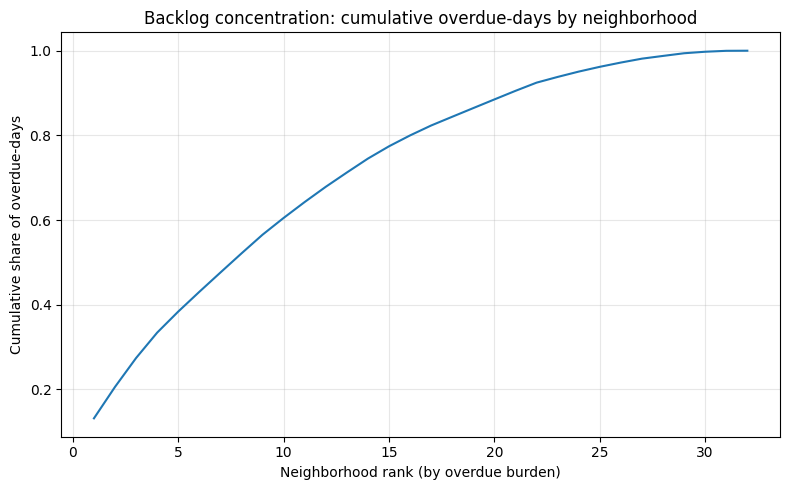

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_insight_backlog_concentration.png


In [ ]:
import matplotlib.pyplot as plt

df = nhood_burden[["nhood", "overdue_days_sum"]].copy()
df = df[df["overdue_days_sum"] > 0].sort_values("overdue_days_sum", ascending=False)
df["cum_share"] = df["overdue_days_sum"].cumsum() / df["overdue_days_sum"].sum()
df["rank"] = np.arange(1, len(df) + 1)

plt.figure(figsize=(8,5))
plt.plot(df["rank"], df["cum_share"])
plt.xlabel("Neighborhood rank (by overdue burden)")
plt.ylabel("Cumulative share of overdue-days")
plt.title("Backlog concentration: cumulative overdue-days by neighborhood")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_insight_backlog_concentration.png", dpi=200)
plt.show()

print("Saved:", OUT_VIZ_DIR / "fig_insight_backlog_concentration.png")

# Best Trend: monthly new cases (from panel) + open backlog (from code)

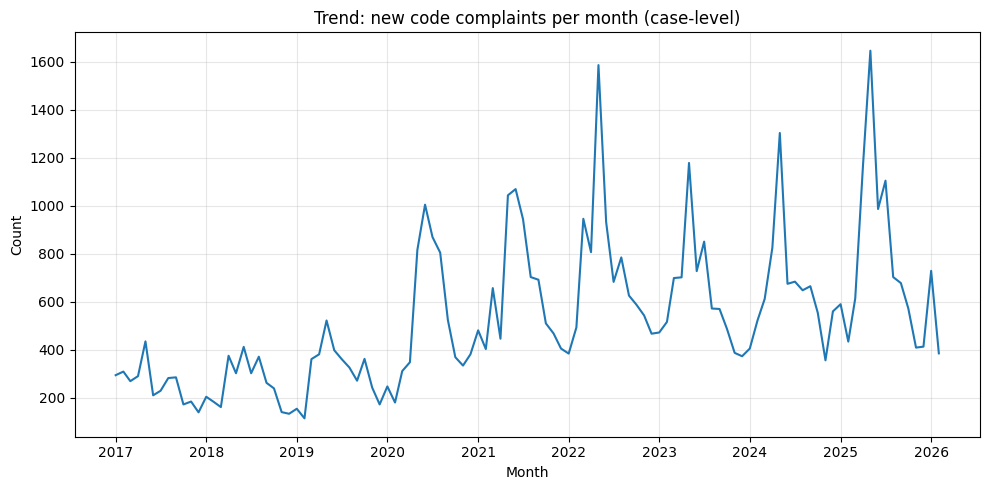

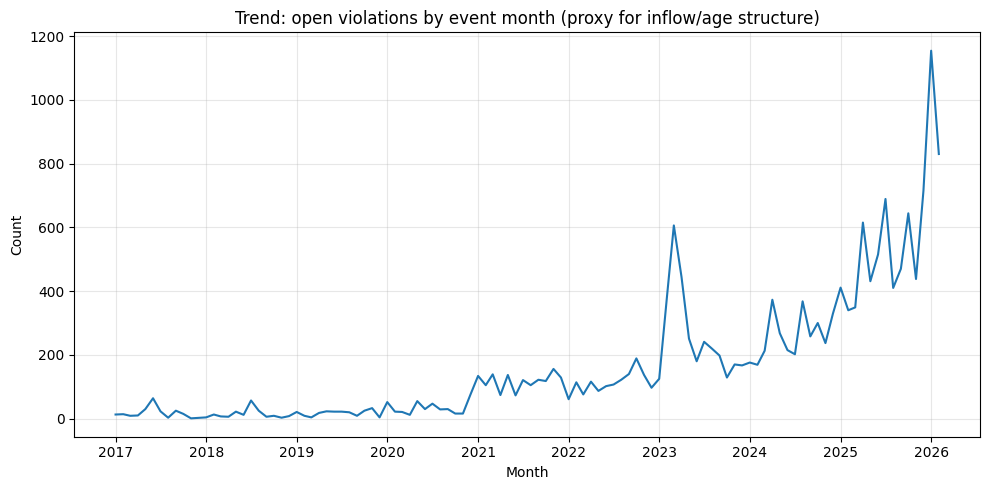

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_trend_new_cases_monthly.png /content/drive/MyDrive/t3_data/outputs/visualizations/fig_trend_open_rows_by_event_month.png


In [ ]:

# Monthly new cases (parcel-month panel already case-level)
ts_cases = (panel.groupby("month")["new_cases"].sum()
            .reset_index()
            .sort_values("month"))

# Monthly open backlog (count open violations by their event month; proxy, not true stock at time)
# Better: create an "as-of open" by status is tricky without close dates; so we show:
# - new open rows/month (open cases created) and
# - current open rows distribution by event month (age structure)
code["month"] = pd.to_datetime(code["event_dt"]).dt.to_period("M").dt.to_timestamp()

ts_new_open = (code[code["is_open"]]
               .groupby("month").size()
               .rename("open_rows_created")
               .reset_index()
               .sort_values("month"))

# Plot
plt.figure(figsize=(10,5))
plt.plot(ts_cases["month"], ts_cases["new_cases"], label="New code cases (complaints)")
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Trend: new code complaints per month (case-level)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_trend_new_cases_monthly.png", dpi=200)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(ts_new_open["month"], ts_new_open["open_rows_created"], label="Open violations (by event month)")
plt.xlabel("Month")
plt.ylabel("Count")
plt.title("Trend: open violations by event month (proxy for inflow/age structure)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_trend_open_rows_by_event_month.png", dpi=200)
plt.show()

print("Saved:",
      OUT_VIZ_DIR / "fig_trend_new_cases_monthly.png",
      OUT_VIZ_DIR / "fig_trend_open_rows_by_event_month.png")

# Best Trend: crime + parking monthly trends (2023+)

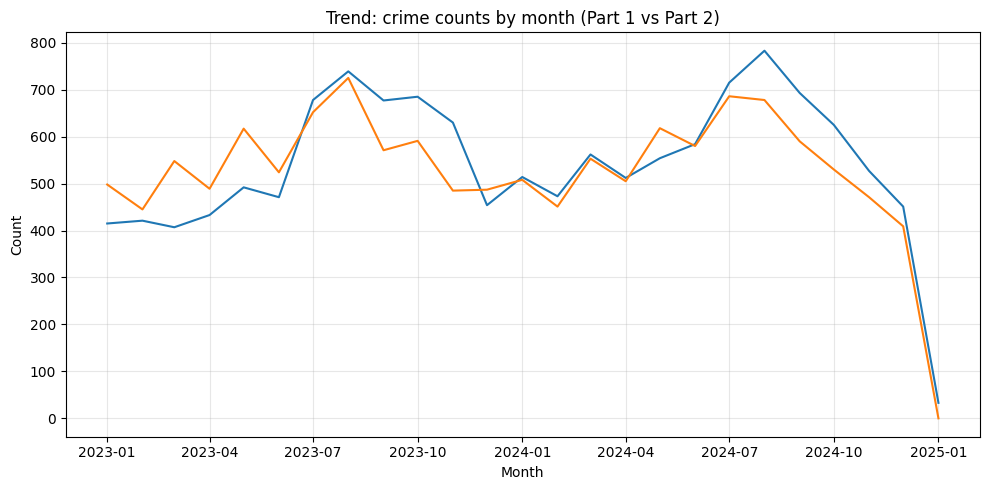

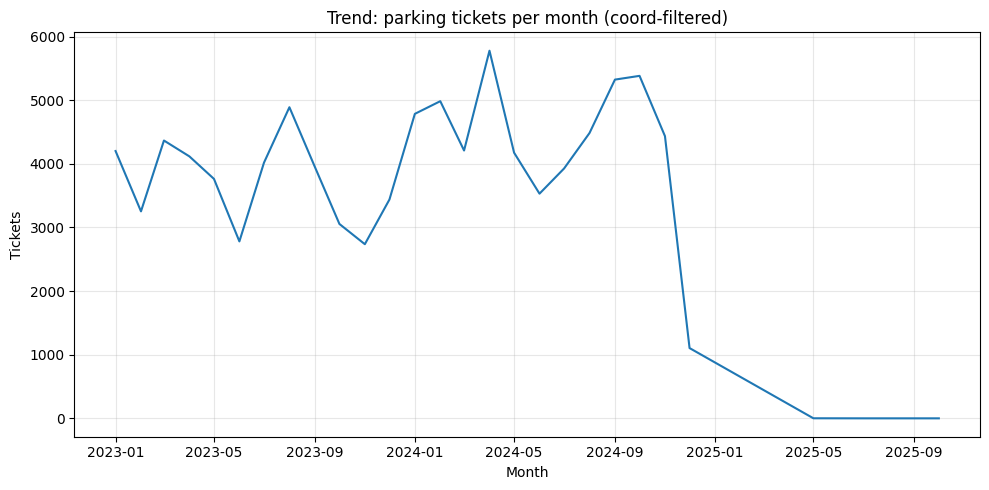

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_trend_crime_monthly_p1_p2.png /content/drive/MyDrive/t3_data/outputs/visualizations/fig_trend_parking_monthly.png


In [ ]:
crime["month"] = pd.to_datetime(crime["event_dt"]).dt.to_period("M").dt.to_timestamp()
crime_ts = (crime.groupby(["month", "part"]).size()
            .rename("cnt").reset_index()
            .pivot_table(index="month", columns="part", values="cnt", fill_value=0)
            .reset_index())

parking_ts = (parking.groupby("month").size()
              .rename("parking_cnt").reset_index()
              .sort_values("month"))

plt.figure(figsize=(10,5))
if "p1" in crime_ts.columns: plt.plot(crime_ts["month"], crime_ts["p1"], label="Crime Part 1")
if "p2" in crime_ts.columns: plt.plot(crime_ts["month"], crime_ts["p2"], label="Crime Part 2")
plt.xlabel("Month"); plt.ylabel("Count")
plt.title("Trend: crime counts by month (Part 1 vs Part 2)")
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_trend_crime_monthly_p1_p2.png", dpi=200)
plt.show()

plt.figure(figsize=(10,5))
plt.plot(parking_ts["month"], parking_ts["parking_cnt"])
plt.xlabel("Month"); plt.ylabel("Tickets")
plt.title("Trend: parking tickets per month (coord-filtered)")
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_trend_parking_monthly.png", dpi=200)
plt.show()

print("Saved:",
      OUT_VIZ_DIR / "fig_trend_crime_monthly_p1_p2.png",
      OUT_VIZ_DIR / "fig_trend_parking_monthly.png")

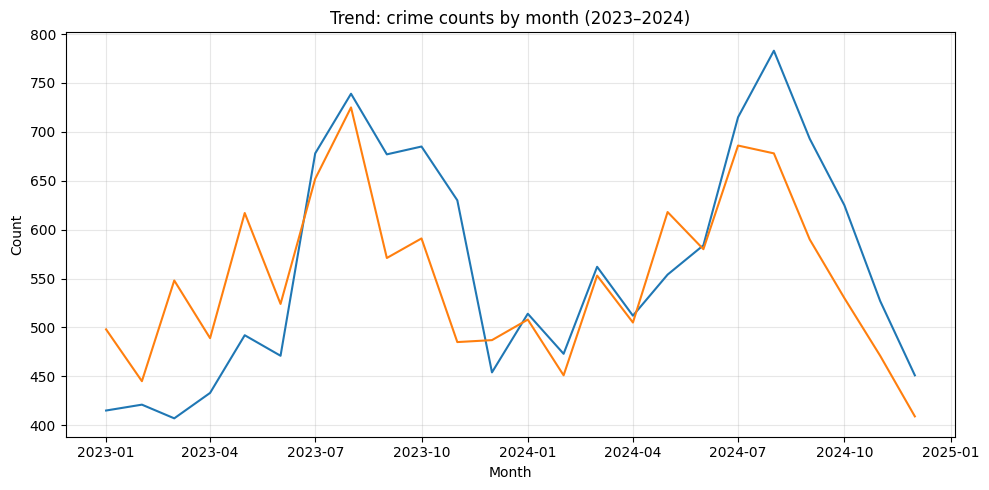

In [ ]:
crime = pd.read_parquet(PROCESSED_DIR / "crime_clean.parquet")
crime["month"] = pd.to_datetime(crime["event_dt"]).dt.to_period("M").dt.to_timestamp()

crime = crime[crime["year"].isin([2023, 2024])].copy()

crime_ts = (crime.groupby(["month", "part"]).size()
            .rename("cnt").reset_index()
            .pivot_table(index="month", columns="part", values="cnt", fill_value=0)
            .reset_index())

plt.figure(figsize=(10,5))
if "p1" in crime_ts.columns: plt.plot(crime_ts["month"], crime_ts["p1"], label="Crime Part 1")
if "p2" in crime_ts.columns: plt.plot(crime_ts["month"], crime_ts["p2"], label="Crime Part 2")
plt.xlabel("Month"); plt.ylabel("Count")
plt.title("Trend: crime counts by month (2023–2024)")
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_trend_crime_monthly_p1_p2_2023_2024.png", dpi=200)
plt.show()

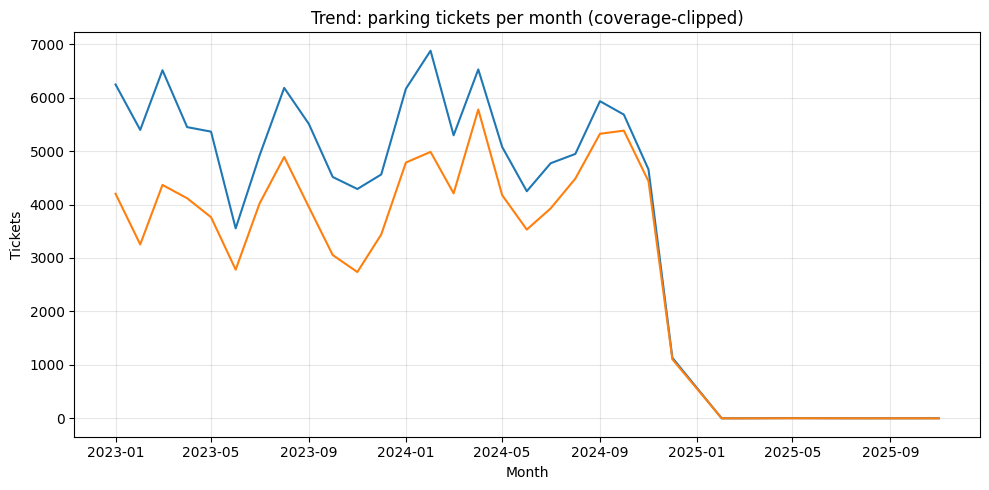

In [ ]:
parking_full = pd.read_parquet(PROCESSED_DIR / "parking_clean.parquet").copy()

code_df = pd.read_parquet(PROCESSED_DIR / "code_with_parcel_attr.parquet", columns=["event_dt"])
ASOF_CODE = pd.to_datetime(code_df["event_dt"]).max()
MAX_DATE = ASOF_CODE + pd.Timedelta(days=30)
MIN_DATE = pd.Timestamp("2023-01-01")
parking_full = parking_full[(parking_full["event_dt"] >= MIN_DATE) & (parking_full["event_dt"] <= MAX_DATE)].copy()

parking_full["month"] = parking_full["event_dt"].dt.to_period("M").dt.to_timestamp()
ts_all = parking_full.groupby("month").size().rename("all_tickets").reset_index()

parking_coord = pd.read_parquet(PROCESSED_DIR / "parking_slim.parquet").copy()
ts_coord = parking_coord.groupby("month").size().rename("coord_tickets").reset_index()

ts = ts_all.merge(ts_coord, on="month", how="left").fillna(0)

last_m = ts.loc[ts["all_tickets"]>0, "month"].max()
ts_clip = ts[ts["month"] <= last_m].copy()

plt.figure(figsize=(10,5))
plt.plot(ts_clip["month"], ts_clip["all_tickets"], label="All tickets (date-filtered)")
plt.plot(ts_clip["month"], ts_clip["coord_tickets"], label="Tickets with coords")
plt.xlabel("Month"); plt.ylabel("Tickets")
plt.title("Trend: parking tickets per month (coverage-clipped)")
plt.grid(True, alpha=0.3); plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_trend_parking_monthly_clipped.png", dpi=200)
plt.show()

In [ ]:
ts_all = (pd.read_parquet(PROCESSED_DIR / "parking_clean.parquet")
          .assign(month=lambda d: d["event_dt"].dt.to_period("M").dt.to_timestamp())
          .groupby("month").size().rename("all_tickets").reset_index())

ts_coord = (pd.read_parquet(PROCESSED_DIR / "parking_slim.parquet")
            .groupby("month").size().rename("coord_tickets").reset_index())

ts = ts_all.merge(ts_coord, on="month", how="left").fillna(0)

print("Last month with any tickets:", ts.loc[ts["all_tickets"]>0, "month"].max())
print("Last month with coord tickets:", ts.loc[ts["coord_tickets"]>0, "month"].max())
print(ts.tail(8))

Last month with any tickets: 2210-02-01 00:00:00
Last month with coord tickets: 2025-10-01 00:00:00
        month  all_tickets  coord_tickets
27 2025-07-01            1            1.0
28 2025-08-01            1            0.0
29 2025-10-01            1            1.0
30 2025-11-01            2            0.0
31 2026-06-01            1            0.0
32 2026-11-01            1            0.0
33 2032-02-01            1            0.0
34 2210-02-01            1            0.0


# Build geodataframes for mapping (nhood polygons + burden + counts)

In [ ]:
nhood_poly = gpd.read_file(PROCESSED_DIR / "nhood_polygons.gpkg").to_crs(epsg=4326)
burden = pd.read_csv(OUT_TAB_DIR / "nhood_overdue_burden.csv")

# Merge overdue burden onto neighborhood polygons
nhood_map = nhood_poly.merge(burden, on="nhood", how="left")
for c in ["open_overdue_rows", "overdue_share", "overdue_days_sum", "overdue_days_median", "overdue_days_p95"]:
    if c in nhood_map.columns:
        nhood_map[c] = nhood_map[c].fillna(0)

# Crime and parking neighborhood-month features
nhood_month = pd.read_parquet(PROCESSED_DIR / "nhood_month_features.parquet")

# Add year for easy filtering
nhood_month["year"] = pd.to_datetime(nhood_month["month"]).dt.year

print("nhood_map rows:", len(nhood_map))
print("nhood_month years:", sorted(nhood_month["year"].unique().tolist()))

nhood_map rows: 33
nhood_month years: [2023, 2024, 2025]


## Choropleth: Compliance-debt burden (log-scaled)

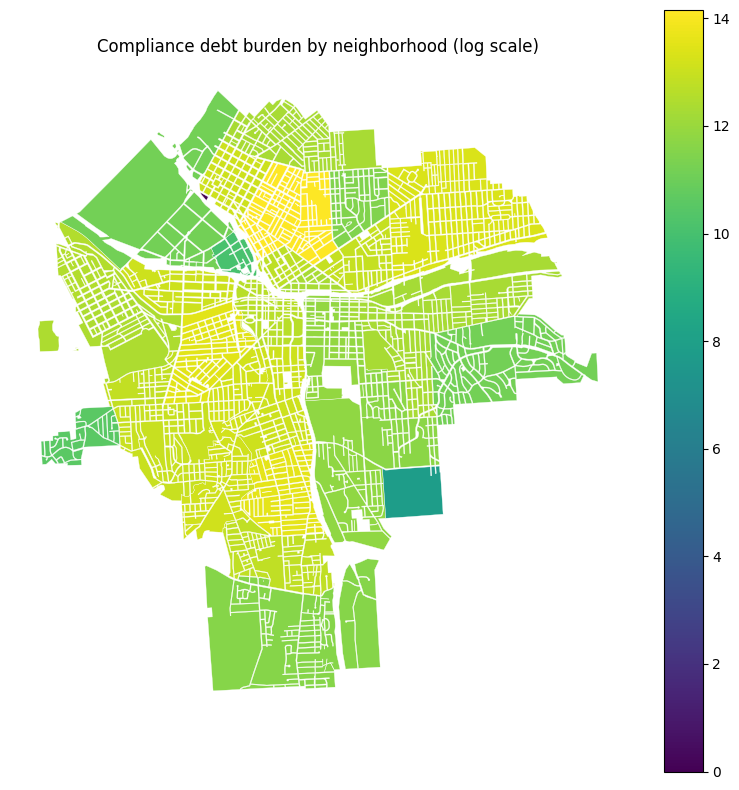

In [ ]:
nhood_map["log_overdue_days_sum"] = np.log1p(nhood_map["overdue_days_sum"])

ax = nhood_map.plot(
    column="log_overdue_days_sum",
    legend=True,
    figsize=(8,8),
    edgecolor="white",
    linewidth=0.25
)
ax.set_title("Compliance debt burden by neighborhood (log scale)")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_map_overdue_burden_log.png", dpi=200)
plt.show()

## Choropleth: Overdue share among open-with-comply-by

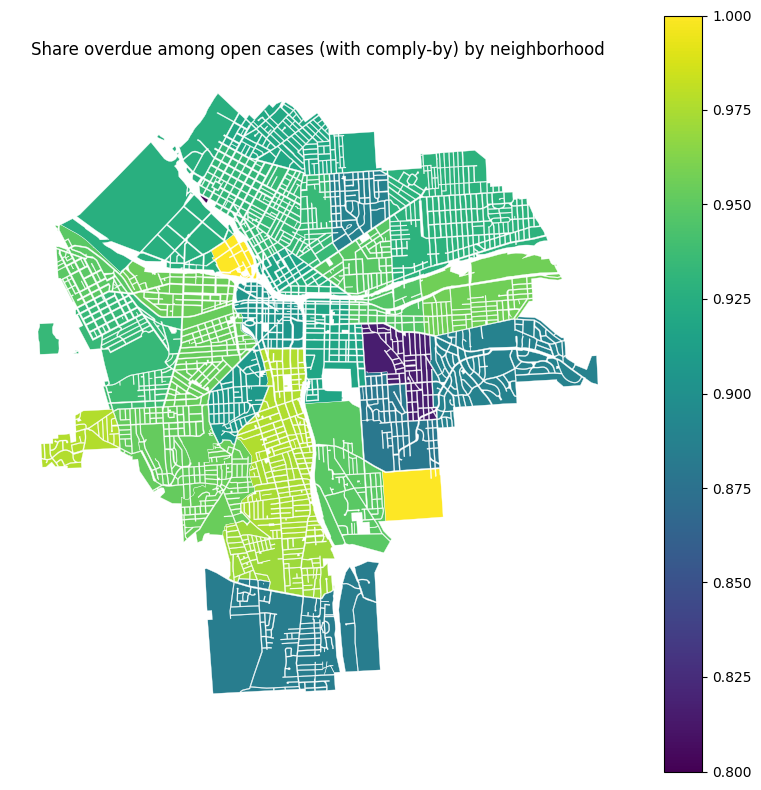

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_map_overdue_share_clipped.png


In [ ]:
vmin, vmax = 0.80, 1.00

ax = nhood_map.plot(
    column="overdue_share",
    legend=True,
    figsize=(8,8),
    vmin=vmin, vmax=vmax,
    edgecolor="white",
    linewidth=0.25
)
ax.set_title("Share overdue among open cases (with comply-by) by neighborhood")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_map_overdue_share_clipped.png", dpi=200)
plt.show()

print("Saved:", OUT_VIZ_DIR / "fig_map_overdue_share_clipped.png")

## Crime maps: 2023 vs 2024 (Part 1 and Part 2)

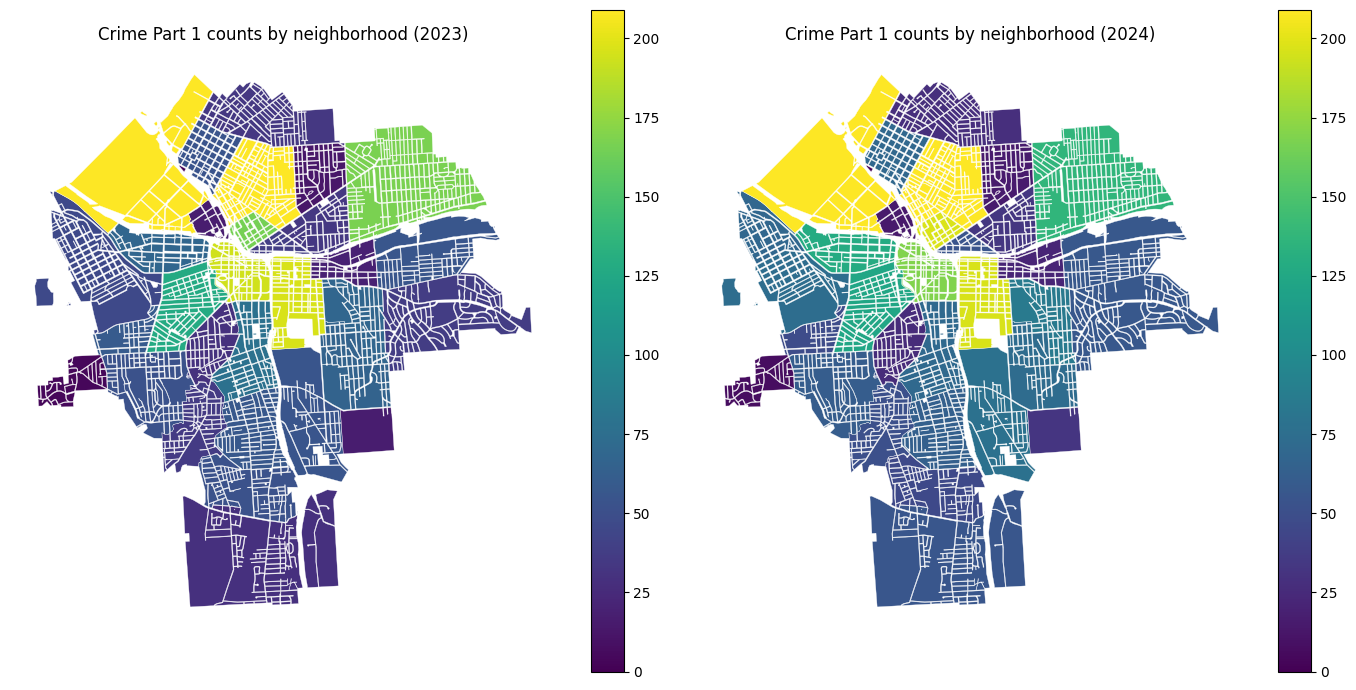

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_map_crime_p1_2023_2024_shared.png | shared vmax: 209.0 | log: False


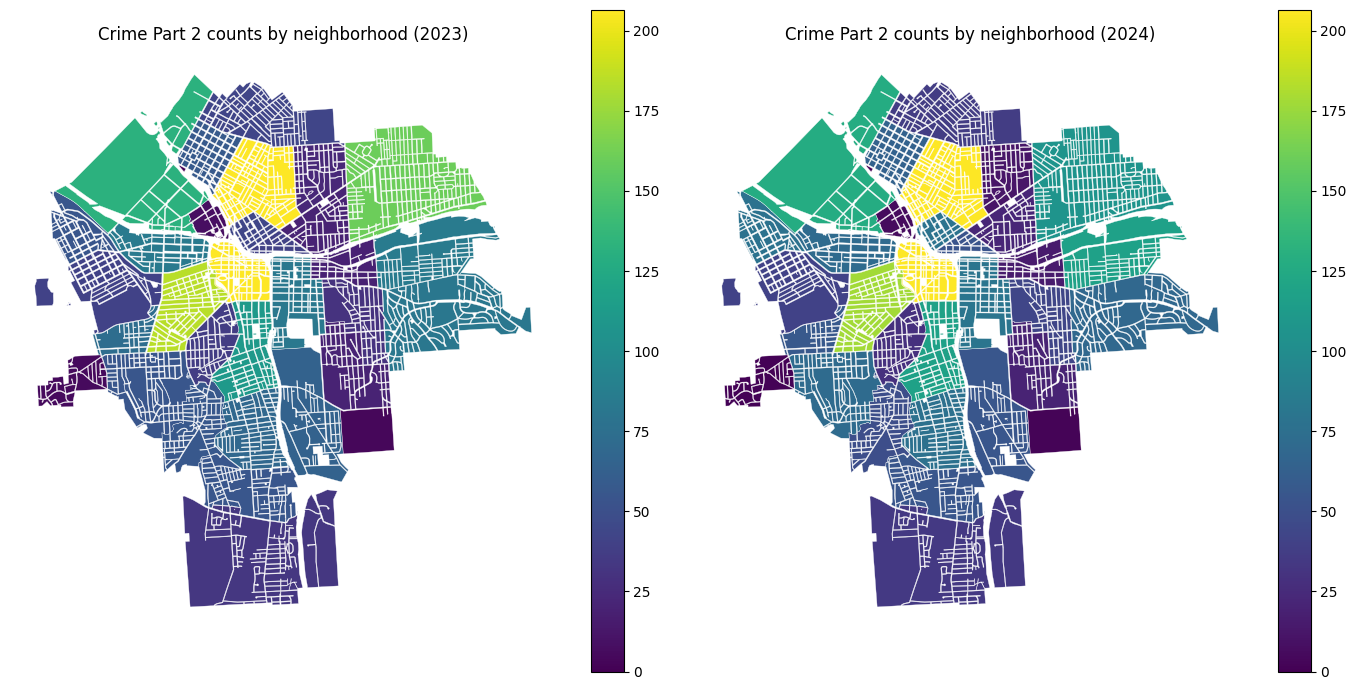

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_map_crime_p2_2023_2024_shared.png | shared vmax: 206.5 | log: False


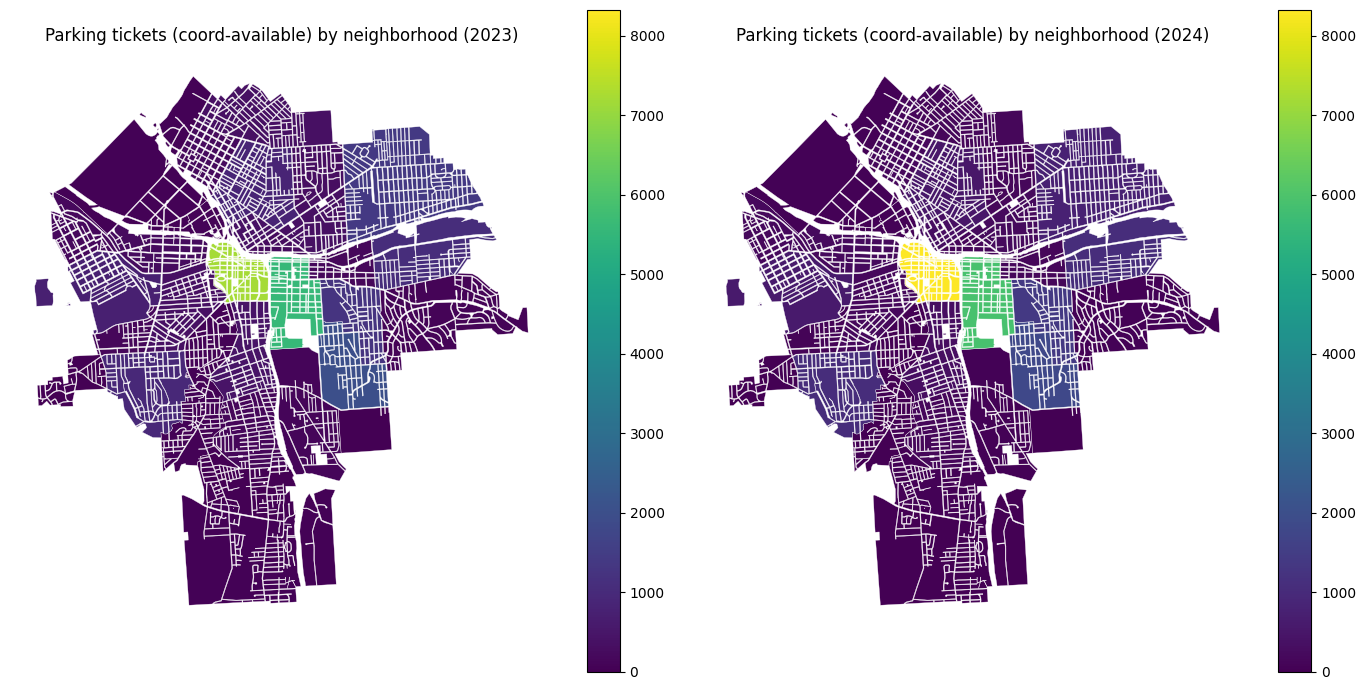

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_map_parking_2023_2024_shared.png | shared vmax: 8324.0 | log: False


In [ ]:
nhood_poly = gpd.read_file(PROCESSED_DIR / "nhood_polygons.gpkg").to_crs(epsg=4326)

# Neighborhood-month features
nhood_month = pd.read_parquet(PROCESSED_DIR / "nhood_month_features.parquet").copy()
nhood_month["year"] = pd.to_datetime(nhood_month["month"]).dt.year

def year_agg(var, year):
    df = (nhood_month[nhood_month["year"] == year]
          .groupby("nhood")[var].sum()
          .rename(var)
          .reset_index())
    gdf = nhood_poly.merge(df, on="nhood", how="left")
    gdf[var] = gdf[var].fillna(0)
    return gdf

def shared_scale_vmax(var, years=(2023, 2024), q=0.95):
    # Use a robust max to avoid one neighborhood dominating the color scale
    vals = []
    for y in years:
        gdf = year_agg(var, y)
        vals.append(gdf[var].values)
    allv = np.concatenate(vals)
    vmax = float(np.quantile(allv, q))
    vmax = max(vmax, 1.0)
    return vmax

def plot_side_by_side(var, year_left, year_right, title, out_name, q=0.95, log=False):
    gdfL = year_agg(var, year_left)
    gdfR = year_agg(var, year_right)

    # Shared scale
    vmax = shared_scale_vmax(var, years=(year_left, year_right), q=q)
    vmin = 0.0

    # Optionally use log transform to improve contrast
    if log:
        gdfL[var + "_plot"] = np.log1p(gdfL[var])
        gdfR[var + "_plot"] = np.log1p(gdfR[var])
        col = var + "_plot"
        vmax = float(np.quantile(np.concatenate([gdfL[col].values, gdfR[col].values]), q))
        vmax = max(vmax, 0.1)
    else:
        col = var

    fig, axes = plt.subplots(1, 2, figsize=(14, 7))

    ax0 = gdfL.plot(column=col, ax=axes[0], legend=True, vmin=vmin, vmax=vmax,
                    edgecolor="white", linewidth=0.25)
    axes[0].set_title(f"{title} ({year_left})")
    axes[0].set_axis_off()

    ax1 = gdfR.plot(column=col, ax=axes[1], legend=True, vmin=vmin, vmax=vmax,
                    edgecolor="white", linewidth=0.25)
    axes[1].set_title(f"{title} ({year_right})")
    axes[1].set_axis_off()

    plt.tight_layout()
    plt.savefig(OUT_VIZ_DIR / out_name, dpi=200)
    plt.show()
    print("Saved:", OUT_VIZ_DIR / out_name, "| shared vmax:", round(vmax, 2), "| log:", log)

# ===== Crime side-by-side (shared scale) =====
# Use q=0.95 for robust shared scaling; set log=True if you want more contrast.
plot_side_by_side("crime_p1", 2023, 2024, "Crime Part 1 counts by neighborhood", "fig_map_crime_p1_2023_2024_shared.png", q=0.95, log=False)
plot_side_by_side("crime_p2", 2023, 2024, "Crime Part 2 counts by neighborhood", "fig_map_crime_p2_2023_2024_shared.png", q=0.95, log=False)

# ===== Parking side-by-side (shared scale) =====
plot_side_by_side("parking_cnt", 2023, 2024, "Parking tickets (coord-available) by neighborhood", "fig_map_parking_2023_2024_shared.png", q=1, log=False)

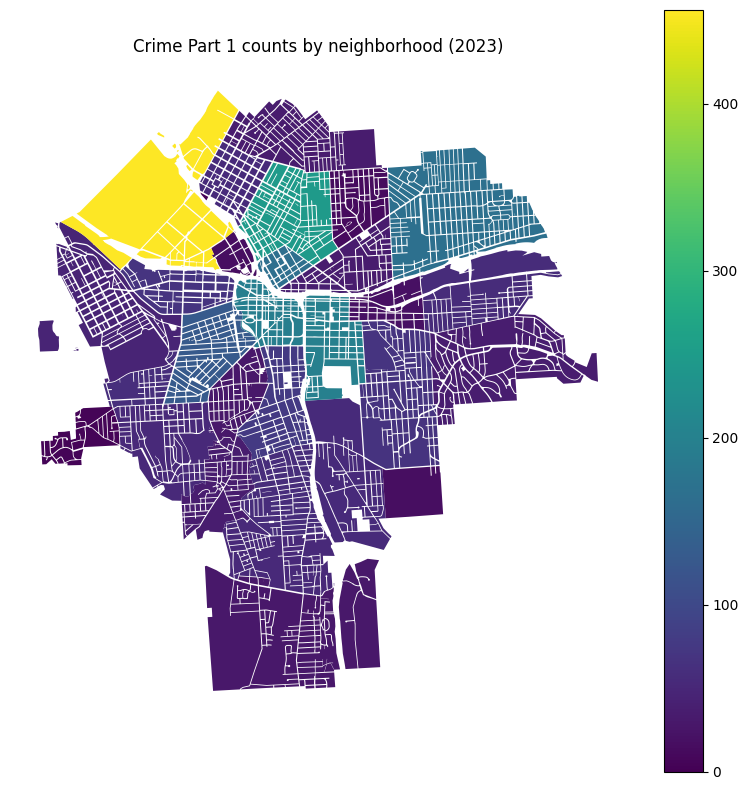

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_map_crime_p1_2023.png


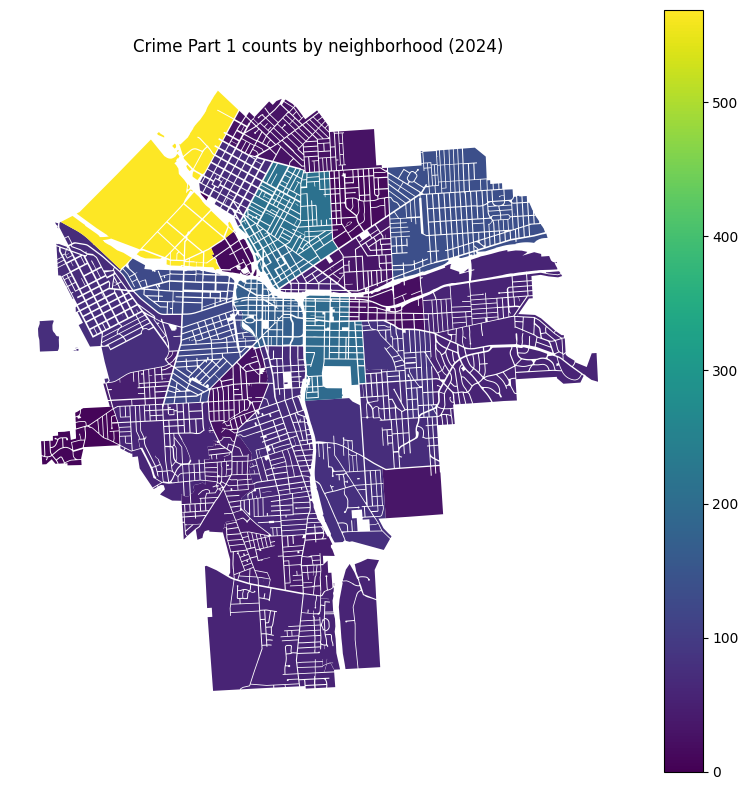

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_map_crime_p1_2024.png


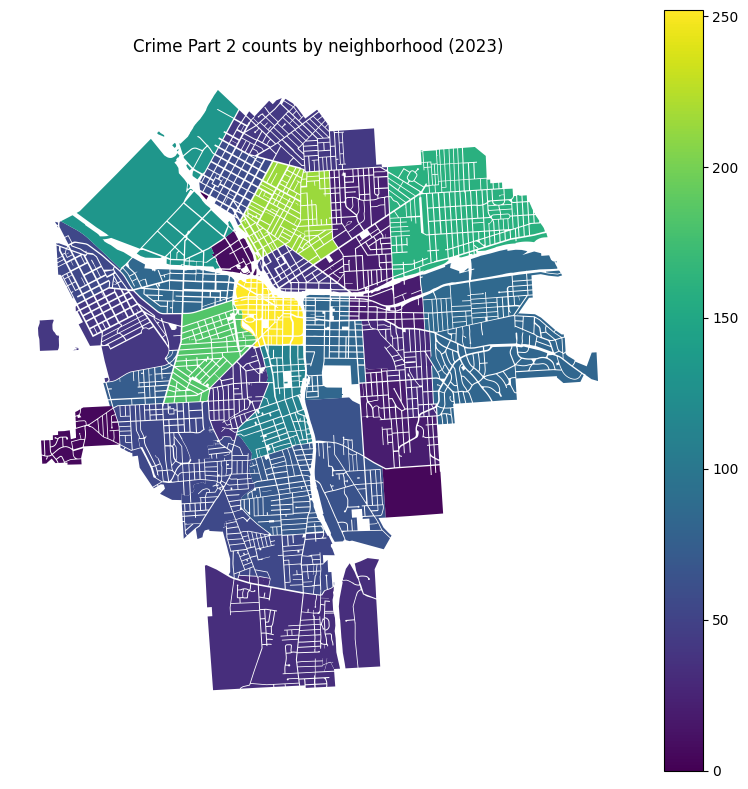

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_map_crime_p2_2023.png


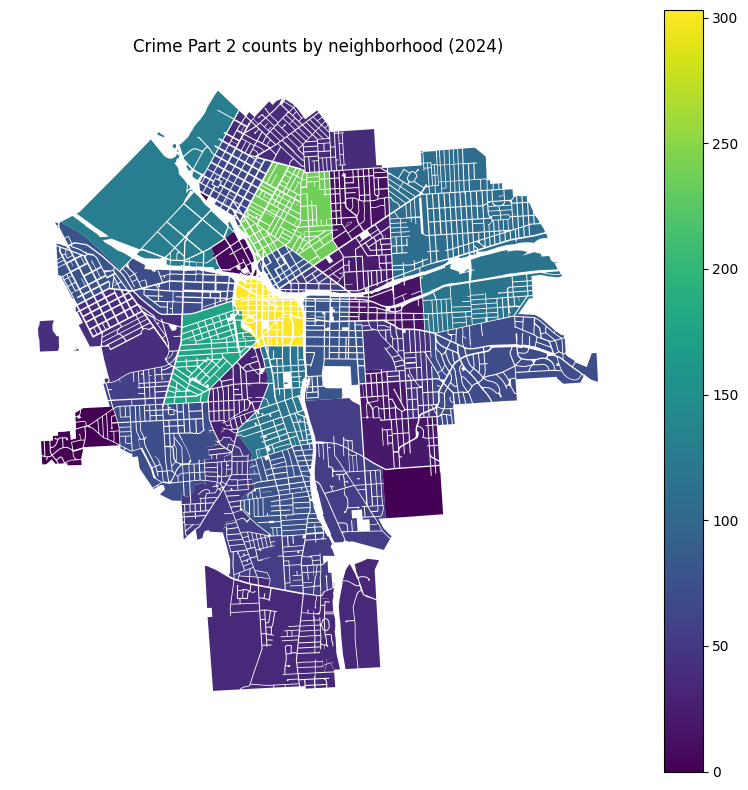

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_map_crime_p2_2024.png


In [ ]:
def map_year(var, year, title, out_name):
    df = (nhood_month[nhood_month["year"] == year]
          .groupby("nhood")[var].sum()
          .rename(var)
          .reset_index())
    gdf = nhood_poly.merge(df, on="nhood", how="left")
    gdf[var] = gdf[var].fillna(0)

    ax = gdf.plot(column=var, legend=True, figsize=(8,8))
    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()
    plt.savefig(OUT_VIZ_DIR / out_name, dpi=200)
    plt.show()
    print("Saved:", OUT_VIZ_DIR / out_name)

map_year("crime_p1", 2023, "Crime Part 1 counts by neighborhood (2023)", "fig_map_crime_p1_2023.png")
map_year("crime_p1", 2024, "Crime Part 1 counts by neighborhood (2024)", "fig_map_crime_p1_2024.png")
map_year("crime_p2", 2023, "Crime Part 2 counts by neighborhood (2023)", "fig_map_crime_p2_2023.png")
map_year("crime_p2", 2024, "Crime Part 2 counts by neighborhood (2024)", "fig_map_crime_p2_2024.png")

## Parking map: 2023 vs 2024 (coord-available tickets)

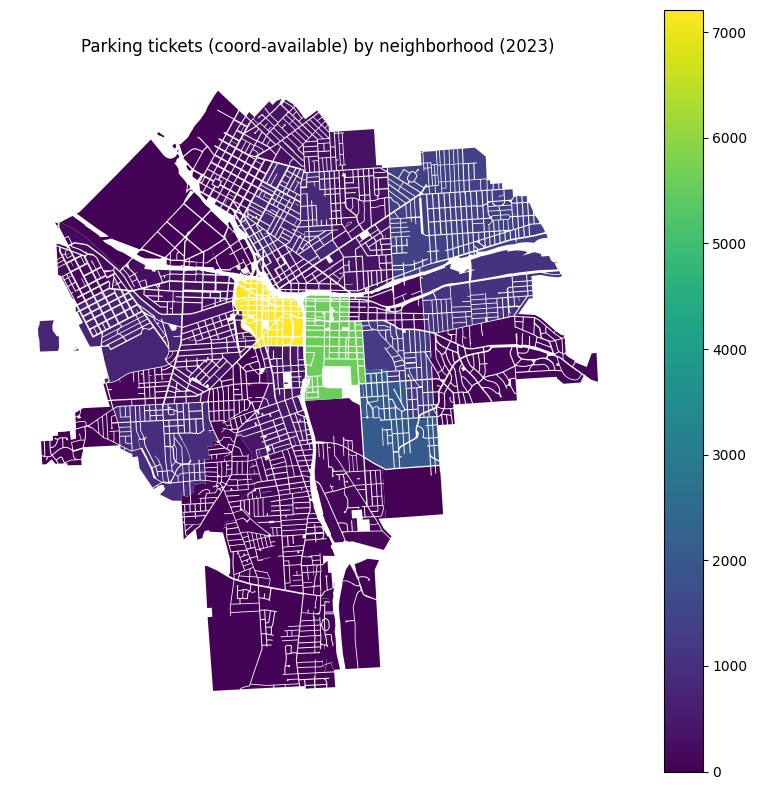

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_map_parking_2023.png


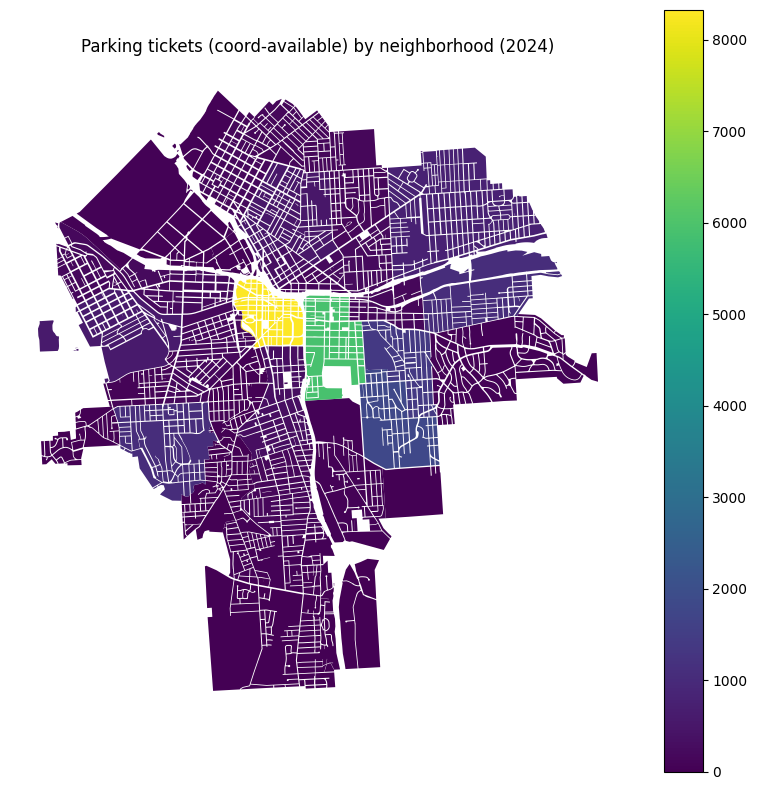

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_map_parking_2024.png


In [ ]:
map_year("parking_cnt", 2023, "Parking tickets (coord-available) by neighborhood (2023)", "fig_map_parking_2023.png")
map_year("parking_cnt", 2024, "Parking tickets (coord-available) by neighborhood (2024)", "fig_map_parking_2024.png")

In [ ]:
# !pip -q install lightgbm shap

# Load modeling table + restrict to stable coverage window (2023–2024)

In [ ]:
panel = pd.read_parquet(PROCESSED_DIR / "panel_parcel_month_fullfeatures.parquet")

panel["month"] = pd.to_datetime(panel["month"])
panel["year"] = panel["month"].dt.year
panel["month_of_year"] = panel["month"].dt.month

# Use 2023–2024 window for consistent crime+parking context
panel_m = panel[(panel["month"] >= "2023-01-01") & (panel["month"] <= "2024-12-01")].copy()

# Target
TARGET = "y_next_1m"
panel_m[TARGET] = panel_m[TARGET].astype(int)

print("Rows:", len(panel_m), "Parcels:", panel_m["sbl"].nunique(), "Months:", panel_m["month"].nunique())
print("Positive rate:", round(panel_m[TARGET].mean()*100, 3), "%")
print("Month range:", panel_m["month"].min(), "->", panel_m["month"].max())

Rows: 422136 Parcels: 17589 Months: 24
Positive rate: 3.468 %
Month range: 2023-01-01 00:00:00 -> 2024-12-01 00:00:00


## Define features (numeric + selected categoricals)

In [ ]:
from sklearn.model_selection import train_test_split

# Drop identifiers + targets
drop_cols = {"sbl", "month", "y_next_1m", "y_next_3m", "last_case_month"}
feature_cols = [c for c in panel_m.columns if c not in drop_cols]

# Keep only columns that are reasonably useful:
# - numeric columns
# - low-cardinality categoricals (<= 100 unique)
num_cols = panel_m[feature_cols].select_dtypes(include=["number", "bool"]).columns.tolist()

cat_candidates = panel_m[feature_cols].select_dtypes(include=["object", "string"]).columns.tolist()
cat_cols = []
for c in cat_candidates:
    nunq = panel_m[c].nunique(dropna=True)
    if 2 <= nunq <= 100:
        cat_cols.append(c)

# Add engineered seasonality fields if not already numeric
for c in ["year", "month_of_year"]:
    if c not in num_cols:
        num_cols.append(c)

X_cols = num_cols + cat_cols
print("Numeric features:", len(num_cols))
print("Categorical features:", len(cat_cols))
print("Example categorical:", cat_cols[:10])

# Convert categoricals to category dtype for LightGBM native handling
for c in cat_cols:
    panel_m[c] = panel_m[c].astype("category")

Numeric features: 42
Categorical features: 24
Example categorical: ['zip', 'luc_parcel', 'lu_parcel', 'lucat_old', 'ipsvacant', 'ips_condit', 'nreligible', 'lpss', 'wtr_active', 'dpw_quad']


# Time-based backtest (4 folds) + metrics (AUC, PR-AUC, Precision@K)

In [ ]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score, average_precision_score
import pandas as pd
import numpy as np

def precision_at_k(y_true, y_score, k_frac):
    """Precision among top k_frac of items (k_frac in (0,1])."""
    n = len(y_true)
    k = max(1, int(np.floor(k_frac * n)))
    idx = np.argsort(-y_score)[:k]
    return float(np.mean(y_true[idx]))

# Pick evaluation months (quarterly in 2024)
eval_months = pd.to_datetime(["2024-03-01", "2024-06-01", "2024-09-01", "2024-12-01"])
k_fracs = [0.005, 0.01, 0.02, 0.05]  # 0.5%, 1%, 2%, 5%

results = []
all_val = []

for m in eval_months:
    train_df = panel_m[panel_m["month"] < m].copy()
    val_df   = panel_m[panel_m["month"] == m].copy()
    if len(val_df) == 0 or len(train_df) == 0:
        continue

    X_train = train_df[X_cols]
    y_train = train_df[TARGET].values
    X_val   = val_df[X_cols]
    y_val   = val_df[TARGET].values

    # Class imbalance handling
    pos_rate = y_train.mean()
    scale_pos_weight = (1 - pos_rate) / max(pos_rate, 1e-6)

    model = lgb.LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.03,
        num_leaves=64,
        min_child_samples=50,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    p = model.predict_proba(X_val)[:, 1]

    fold = {
        "eval_month": m,
        "n_train": len(train_df),
        "n_val": len(val_df),
        "pos_rate_train": float(pos_rate),
        "pos_rate_val": float(y_val.mean()),
        "roc_auc": float(roc_auc_score(y_val, p)) if len(np.unique(y_val)) > 1 else np.nan,
        "pr_auc": float(average_precision_score(y_val, p))
    }

    for kf in k_fracs:
        fold[f"precision_at_{int(kf*1000)/10:.1f}pct"] = precision_at_k(y_val, p, kf)

    results.append(fold)

    tmp = val_df[["sbl", "month"]].copy()
    tmp["y_true"] = y_val
    tmp["y_score"] = p
    all_val.append(tmp)

cv_df = pd.DataFrame(results)
display(cv_df)

cv_df.to_csv(OUT_TAB_DIR / "model_cv_results.csv", index=False)
print("Saved:", OUT_TAB_DIR / "model_cv_results.csv")

val_all = pd.concat(all_val, ignore_index=True)
print("Total backtest rows:", len(val_all), "Positive rate:", round(val_all["y_true"].mean()*100, 3), "%")

[LightGBM] [Info] Number of positive: 8125, number of negative: 238121
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179282 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6209
[LightGBM] [Info] Number of data points in the train set: 246246, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032995 -> initscore=-3.377833
[LightGBM] [Info] Start training from score -3.377833
[LightGBM] [Info] Number of positive: 10795, number of negative: 288218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.193503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6308
[LightGBM] [Info] Number of data points in the train set: 299013, number of used features: 66
[LightGBM] [Inf

eval_month  n_train  n_val  pos_rate_train  pos_rate_val   roc_auc    pr_auc  precision_at_0.5pct  precision_at_1.0pct  \
0 2024-03-01   246246  17589        0.032995      0.044175  0.645952  0.078464             0.241379             0.188571   
1 2024-06-01   299013  17589        0.036102      0.037467  0.625935  0.062226             0.252874             0.142857   
2 2024-09-01   351780  17589        0.036119      0.029393  0.698649  0.071974             0.218391             0.171429   
3 2024-12-01   404547  17589        0.034809      0.031724  0.679925  0.075635             0.321839             0.182857   

   precision_at_2.0pct  precision_at_5.0pct  
0             0.131054             0.095563  
1             0.105413             0.080774  
2             0.113960             0.088737  
3             0.150997             0.095563

Saved: /content/drive/MyDrive/t3_data/outputs/tables/model_cv_results.csv
Total backtest rows: 70356 Positive rate: 3.569 %


# Plot Precision@K (averaged across folds) + PR curve on pooled validation

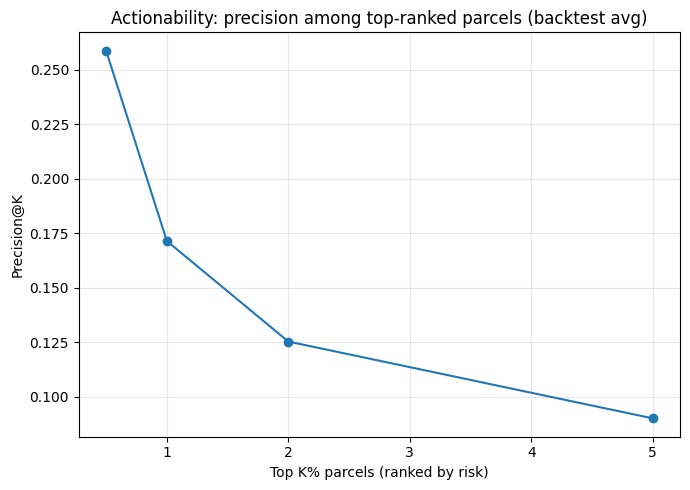

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_pred_precision_at_k.png


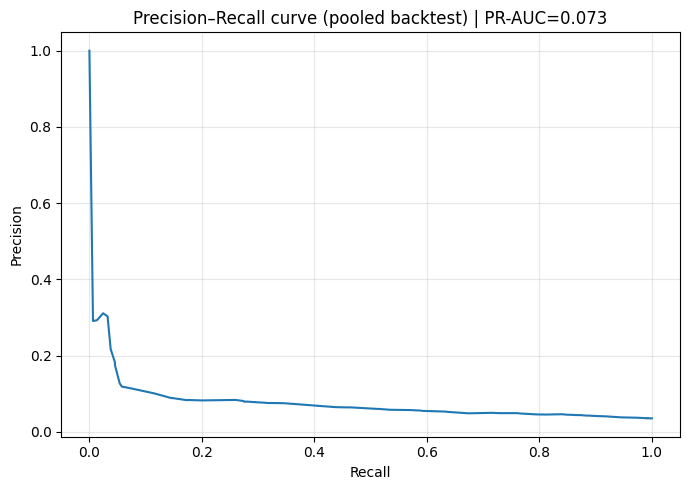

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_pred_pr_curve.png


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Precision@K (average across folds)
k_labels = [f"precision_at_{int(kf*1000)/10:.1f}pct" for kf in k_fracs]
mean_prec = [cv_df[c].mean() for c in k_labels]

plt.figure(figsize=(7,5))
plt.plot([kf*100 for kf in k_fracs], mean_prec, marker="o")
plt.xlabel("Top K% parcels (ranked by risk)")
plt.ylabel("Precision@K")
plt.title("Actionability: precision among top-ranked parcels (backtest avg)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_pred_precision_at_k.png", dpi=200)
plt.show()
print("Saved:", OUT_VIZ_DIR / "fig_pred_precision_at_k.png")

# Pooled PR curve
y_true = val_all["y_true"].values
y_score = val_all["y_score"].values
prec, rec, thr = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)

plt.figure(figsize=(7,5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall curve (pooled backtest) | PR-AUC={ap:.3f}")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_pred_pr_curve.png", dpi=200)
plt.show()
print("Saved:", OUT_VIZ_DIR / "fig_pred_pr_curve.png")

# Train final model (through 2024-12) + produce “next-month” risk list (predict Jan 2025 from Dec 2024)

In [ ]:
# 06F-FIX — Train final model (2023–2024) and generate Dec-2024 risk scores (forecast Jan-2025)
# ---- Load and filter to stable window ----
panel_m = pd.read_parquet(PROCESSED_DIR / "panel_parcel_month_fullfeatures.parquet")
panel_m["month"] = pd.to_datetime(panel_m["month"])
panel_m["year"] = panel_m["month"].dt.year
panel_m["month_of_year"] = panel_m["month"].dt.month

panel_m = panel_m[(panel_m["month"] >= "2023-01-01") & (panel_m["month"] <= "2024-12-01")].copy()

TARGET = "y_next_1m"
panel_m[TARGET] = panel_m[TARGET].astype(int)

# ---- Build feature lists (same logic as before) ----
drop_cols = {"sbl", "month", "y_next_1m", "y_next_3m", "last_case_month"}
feature_cols = [c for c in panel_m.columns if c not in drop_cols]

num_cols = panel_m[feature_cols].select_dtypes(include=["number", "bool"]).columns.tolist()

cat_candidates = panel_m[feature_cols].select_dtypes(include=["object", "string"]).columns.tolist()
cat_cols = []
for c in cat_candidates:
    nunq = panel_m[c].nunique(dropna=True)
    if 2 <= nunq <= 100:
        cat_cols.append(c)

for c in ["year", "month_of_year"]:
    if c not in num_cols:
        num_cols.append(c)

X_cols = num_cols + cat_cols

# ---- Create X, then DROP duplicated column names (prevents .cat dataframe slicing issues) ----
X_all = panel_m[X_cols].copy()

dup_names = X_all.columns[X_all.columns.duplicated()].tolist()
if dup_names:
    print("Dropping duplicated feature columns (keeping first occurrence):", dup_names[:15], "..." if len(dup_names) > 15 else "")
    X_all = X_all.loc[:, ~X_all.columns.duplicated()]
    # Update lists after dropping dups
    X_cols = list(X_all.columns)
    cat_cols = [c for c in cat_cols if c in X_cols]

# ---- Convert categoricals to category dtype and FREEZE category levels ----
cat_levels = {}
for c in cat_cols:
    X_all[c] = X_all[c].astype("category")
    cat_levels[c] = X_all[c].cat.categories  # freeze training levels

y_all = panel_m[TARGET].values

print("Training rows:", len(panel_m), "| positive rate:", round(y_all.mean()*100, 3), "%")
print("Num features:", len([c for c in X_cols if c not in cat_cols]),
      "| Cat features:", len(cat_cols), "| Total:", len(X_cols))

# ---- Train final model ----
pos_rate = float(y_all.mean())
scale_pos_weight = (1 - pos_rate) / max(pos_rate, 1e-6)

final_model = lgb.LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=64,
    min_child_samples=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)
final_model.fit(X_all, y_all)

# ---- Forecast: use Dec 2024 rows to score risk for Jan 2025 ----
PRED_MONTH = pd.Timestamp("2024-12-01")
pred_base = panel_m.loc[panel_m["month"] == PRED_MONTH, ["sbl", "month", "nhood"]].copy()
X_pred = panel_m.loc[panel_m["month"] == PRED_MONTH, X_cols].copy()

# Apply SAME categorical levels as training (this fixes your current error)
for c in cat_cols:
    X_pred[c] = X_pred[c].astype("category").cat.set_categories(cat_levels[c])

pred_scores = final_model.predict_proba(X_pred)[:, 1]

pred_out = pred_base.copy()
pred_out["risk_score"] = pred_scores
pred_out = pred_out.sort_values("risk_score", ascending=False)

out_path = OUT_TAB_DIR / "parcel_risk_forecast_2025_01_from_2024_12.csv"
pred_out.to_csv(out_path, index=False)

print("Saved:", out_path)
display(pred_out.head(20))

Training rows: 422136 | positive rate: 3.468 %
Num features: 42 | Cat features: 24 | Total: 66
[LightGBM] [Info] Number of positive: 14640, number of negative: 407496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.223758 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6403
[LightGBM] [Info] Number of data points in the train set: 422136, number of used features: 66
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034681 -> initscore=-3.326274
[LightGBM] [Info] Start training from score -3.326274
Saved: /content/drive/MyDrive/t3_data/outputs/tables/parcel_risk_forecast_2025_01_from_2024_12.csv


sbl      month              nhood  risk_score
1045095  063.-02-16.0 2024-12-01       South Valley    0.983173
1930265  114.-02-05.6 2024-12-01          Lakefront    0.981630
1045205  063.-02-17.0 2024-12-01       South Valley    0.979791
1092285  070.-03-01.0 2024-12-01       North Valley    0.979674
1091295  070.-02-04.0 2024-12-01       North Valley    0.975209
1045425  063.-02-19.0 2024-12-01       South Valley    0.974119
1078755  069.-02-16.0 2024-12-01       South Valley    0.970621
1016165  058.-09-19.0 2024-12-01     Outer Comstock    0.967225
467155   018.-01-06.0 2024-12-01       Hawley-Green    0.966356
1399405  083.-08-24.0 2024-12-01            Elmwood    0.965514
145735   007.-12-01.0 2024-12-01  Washington Square    0.965080
1148715  072.-14-02.0 2024-12-01       North Valley    0.964600
356825   013.-10-01.0 2024-12-01           Sedgwick    0.962826
1044985  063.-02-15.0 2024-12-01       South Valley    0.962733
767675   036.-01-18.0 2024-12-01      Near Eastside    0.961088
1737985  103.-05-01.0 2024-12-01       Hawley-Green    0.960829
1330875  078.-11-10.0 2024-12-01           Brighton    0.959696
1629965  093.-02-34.0 2024-12-01      Near Westside    0.955296
773945   036.-08-01.0 2024-12-01       Salt Springs    0.951035
1738535  103.-05-10.0 2024-12-01       Hawley-Green    0.949373

# Feature importance plot (top 25)

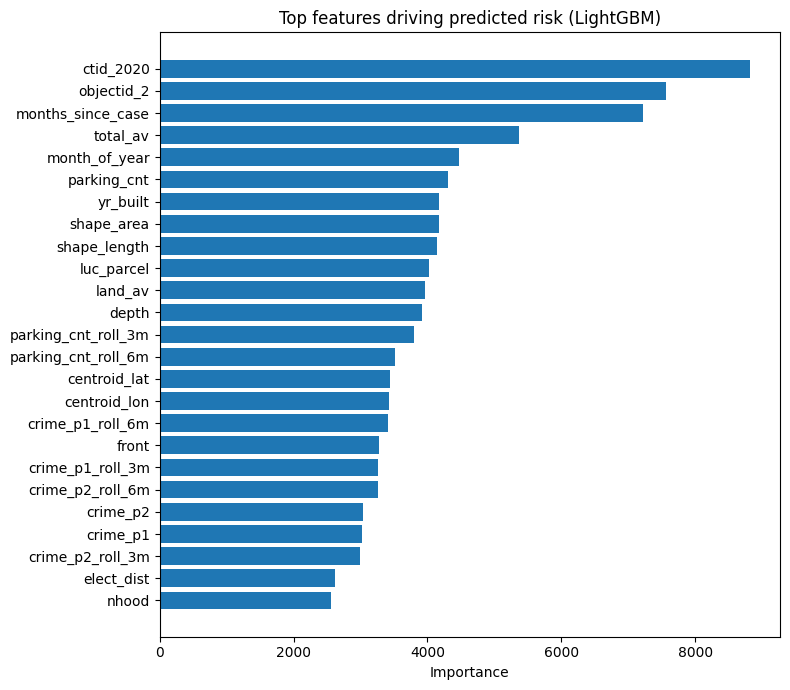

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_pred_feature_importance.png
Saved: /content/drive/MyDrive/t3_data/outputs/tables/model_feature_importance.csv


In [ ]:
imp = pd.DataFrame({
    "feature": X_cols,
    "importance": final_model.feature_importances_
}).sort_values("importance", ascending=False)

top = imp.head(25).iloc[::-1]  # reverse for horizontal bar readability

plt.figure(figsize=(8,7))
plt.barh(top["feature"], top["importance"])
plt.xlabel("Importance")
plt.title("Top features driving predicted risk (LightGBM)")
plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_pred_feature_importance.png", dpi=200)
plt.show()

imp.to_csv(OUT_TAB_DIR / "model_feature_importance.csv", index=False)
print("Saved:", OUT_VIZ_DIR / "fig_pred_feature_importance.png")
print("Saved:", OUT_TAB_DIR / "model_feature_importance.csv")

# summary table

In [ ]:
cv = pd.read_csv(OUT_TAB_DIR / "model_cv_results.csv")

baseline = cv["pos_rate_val"].mean()
summary = {
    "baseline_positive_rate": baseline,
    "mean_pr_auc": cv["pr_auc"].mean(),
    "mean_roc_auc": cv["roc_auc"].mean(),
    "precision_at_0.5pct": cv["precision_at_0.5pct"].mean(),
    "precision_at_1.0pct": cv["precision_at_1.0pct"].mean(),
    "precision_at_2.0pct": cv["precision_at_2.0pct"].mean(),
    "precision_at_5.0pct": cv["precision_at_5.0pct"].mean(),
}
summary["lift_at_0.5pct"] = summary["precision_at_0.5pct"] / baseline
summary["lift_at_1.0pct"] = summary["precision_at_1.0pct"] / baseline
summary["lift_at_2.0pct"] = summary["precision_at_2.0pct"] / baseline
summary["lift_at_5.0pct"] = summary["precision_at_5.0pct"] / baseline

summary_df = pd.DataFrame([summary])
display(summary_df)

summary_df.to_csv(OUT_TAB_DIR / "model_actionability_summary.csv", index=False)
print("Saved:", OUT_TAB_DIR / "model_actionability_summary.csv")

baseline_positive_rate  mean_pr_auc  mean_roc_auc  precision_at_0.5pct  precision_at_1.0pct  precision_at_2.0pct  precision_at_5.0pct  \
0                 0.03569     0.072075      0.662615             0.258621             0.171429             0.125356             0.090159   

   lift_at_0.5pct  lift_at_1.0pct  lift_at_2.0pct  lift_at_5.0pct  
0        7.246323        4.803277        3.512368        2.526183

Saved: /content/drive/MyDrive/t3_data/outputs/tables/model_actionability_summary.csv


# risk map

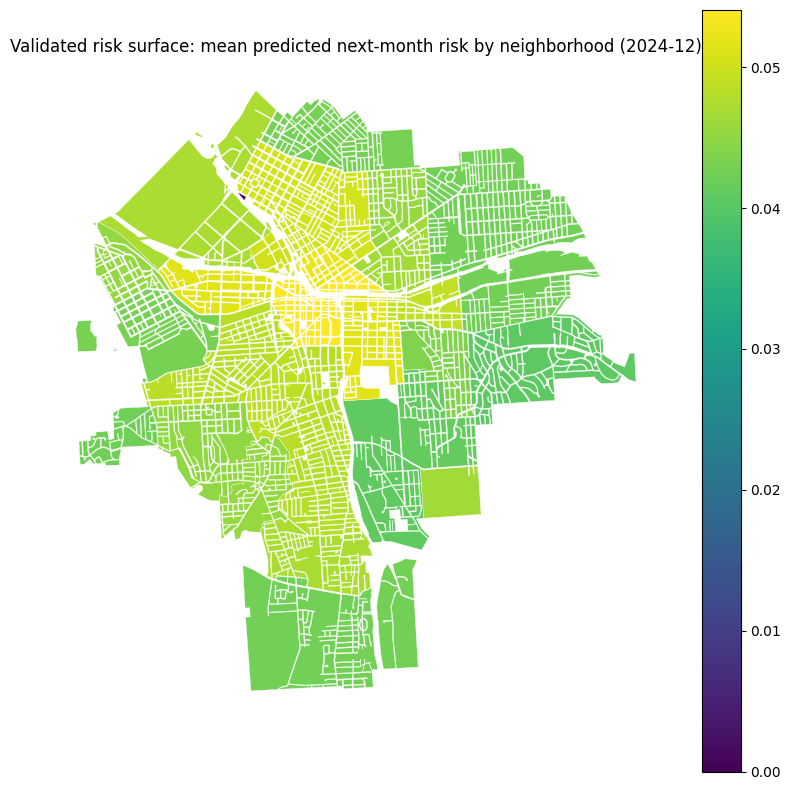

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_pred_risk_map_validated_2024_12.png
Saved: /content/drive/MyDrive/t3_data/outputs/tables/nhood_risk_validated_2024_12.csv


In [ ]:

VAL_MONTH = pd.Timestamp("2024-12-01")

# Attach neighborhood to val predictions
val_map = val_all[val_all["month"] == VAL_MONTH].merge(
    panel_m.loc[panel_m["month"] == VAL_MONTH, ["sbl", "month", "nhood"]],
    on=["sbl", "month"],
    how="left"
)

# Aggregate to neighborhood: mean predicted risk and actual hit rate
nhood_risk = (val_map.groupby("nhood")
              .agg(mean_risk=("y_score", "mean"),
                   actual_rate=("y_true", "mean"),
                   n=("y_true", "size"))
              .reset_index())

# Map
nhood_poly = gpd.read_file(PROCESSED_DIR / "nhood_polygons.gpkg").to_crs(epsg=4326)
gdf = nhood_poly.merge(nhood_risk, on="nhood", how="left")
gdf["mean_risk"] = gdf["mean_risk"].fillna(0)

ax = gdf.plot(column="mean_risk", legend=True, figsize=(8,8), edgecolor="white", linewidth=0.25)
ax.set_title(f"Validated risk surface: mean predicted next-month risk by neighborhood ({VAL_MONTH:%Y-%m})")
ax.set_axis_off()
plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_pred_risk_map_validated_2024_12.png", dpi=200)
plt.show()

print("Saved:", OUT_VIZ_DIR / "fig_pred_risk_map_validated_2024_12.png")

# Save table too
nhood_risk.sort_values("mean_risk", ascending=False).to_csv(
    OUT_TAB_DIR / "nhood_risk_validated_2024_12.csv", index=False
)
print("Saved:", OUT_TAB_DIR / "nhood_risk_validated_2024_12.csv")

Dropped ID-like features: 5
Final feature count: 61 | cat: 24
[LightGBM] [Info] Number of positive: 8125, number of negative: 238121
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218034 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4934
[LightGBM] [Info] Number of data points in the train set: 246246, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.032995 -> initscore=-3.377833
[LightGBM] [Info] Start training from score -3.377833
[LightGBM] [Info] Number of positive: 10795, number of negative: 288218
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.235866 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5033
[LightGBM] [Info] Number of data points in the train set: 299013, number of used features: 61
[LightGBM] [Info]

eval_month  n_train  n_val  pos_rate_train  pos_rate_val   roc_auc    pr_auc  precision_at_0.5pct  precision_at_1.0pct  \
0 2024-03-01   246246  17589        0.032995      0.044175  0.667101  0.087065             0.183908             0.125714   
1 2024-06-01   299013  17589        0.036102      0.037467  0.622232  0.061223             0.218391             0.114286   
2 2024-09-01   351780  17589        0.036119      0.029393  0.696762  0.071475             0.206897             0.171429   
3 2024-12-01   404547  17589        0.034809      0.031724  0.688849  0.076553             0.287356             0.171429   

   precision_at_2.0pct  precision_at_5.0pct  
0             0.156695             0.134243  
1             0.096866             0.055745  
2             0.113960             0.087600  
3             0.111111             0.079636

Saved: /content/drive/MyDrive/t3_data/outputs/tables/model_cv_results_hygiene.csv


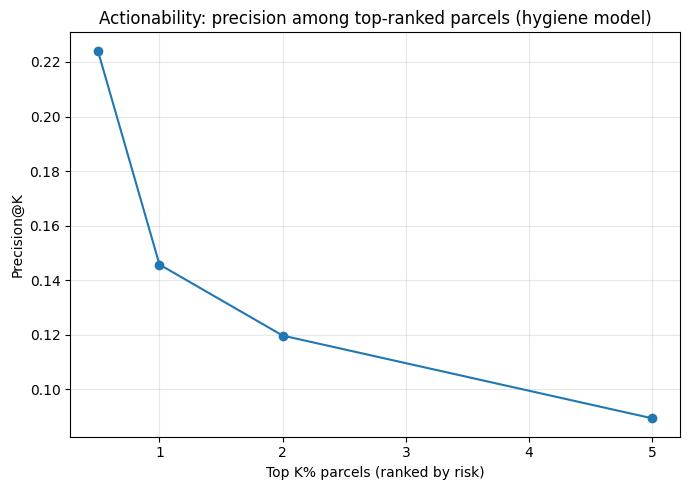

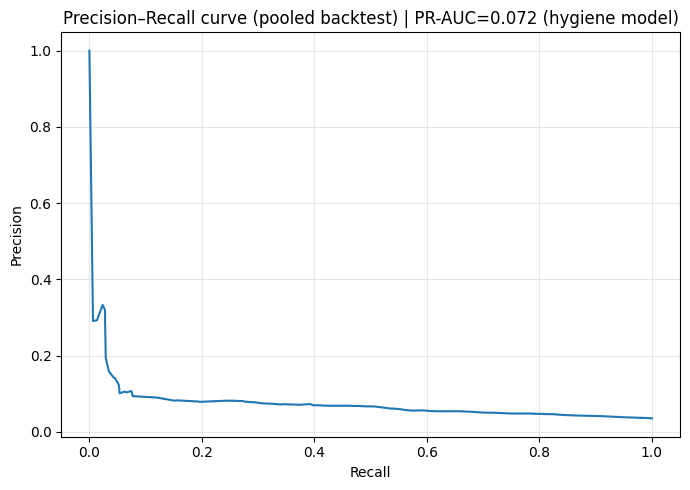

baseline_positive_rate  mean_pr_auc  mean_roc_auc  precision_at_0.5pct  precision_at_1.0pct  precision_at_2.0pct  precision_at_5.0pct  \
0                 0.03569     0.074079      0.668736             0.224138             0.145714             0.119658             0.089306   

   lift_at_0.5pct  lift_at_1.0pct  lift_at_2.0pct  lift_at_5.0pct  
0        6.280147        4.082785        3.352715        2.502276

Saved: /content/drive/MyDrive/t3_data/outputs/tables/model_actionability_summary_hygiene.csv
[LightGBM] [Info] Number of positive: 14640, number of negative: 407496
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.201966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5128
[LightGBM] [Info] Number of data points in the train set: 422136, number of used features: 61
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034681 -> initscore=-3.326274
[LightGBM] [Info] Start training from score -3.326274
Saved: /content/drive/MyDrive/t3_data/outputs/tables/parcel_risk_forecast_2025_01_from_2024_12_hygiene.csv


sbl      month         nhood  risk_score
1045205  063.-02-17.0 2024-12-01  South Valley    0.984561
1930265  114.-02-05.6 2024-12-01     Lakefront    0.982585
1091295  070.-02-04.0 2024-12-01  North Valley    0.981730
1045095  063.-02-16.0 2024-12-01  South Valley    0.980997
1092285  070.-03-01.0 2024-12-01  North Valley    0.977090
1148715  072.-14-02.0 2024-12-01  North Valley    0.973192
1078755  069.-02-16.0 2024-12-01  South Valley    0.972862
1045425  063.-02-19.0 2024-12-01  South Valley    0.971689
1399405  083.-08-24.0 2024-12-01       Elmwood    0.970140
1044985  063.-02-15.0 2024-12-01  South Valley    0.969365

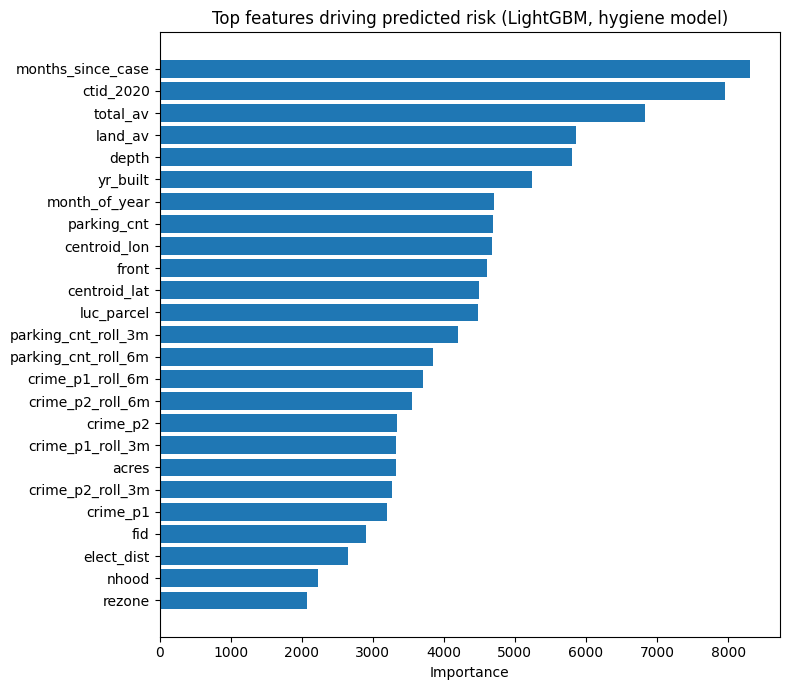

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_pred_feature_importance_hygiene.png
Saved: /content/drive/MyDrive/t3_data/outputs/tables/model_feature_importance_hygiene.csv


In [ ]:

import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

# -----------------------------
# Load & filter to stable window
# -----------------------------
panel_m = pd.read_parquet(PROCESSED_DIR / "panel_parcel_month_fullfeatures.parquet")
panel_m["month"] = pd.to_datetime(panel_m["month"])
panel_m["year"] = panel_m["month"].dt.year
panel_m["month_of_year"] = panel_m["month"].dt.month

panel_m = panel_m[(panel_m["month"] >= "2023-01-01") & (panel_m["month"] <= "2024-12-01")].copy()

TARGET = "y_next_1m"
panel_m[TARGET] = panel_m[TARGET].astype(int)

# -----------------------------
# Feature selection
# -----------------------------
drop_cols = {"sbl", "month", "y_next_1m", "y_next_3m", "last_case_month"}
feature_cols = [c for c in panel_m.columns if c not in drop_cols]

num_cols = panel_m[feature_cols].select_dtypes(include=["number", "bool"]).columns.tolist()
cat_candidates = panel_m[feature_cols].select_dtypes(include=["object", "string"]).columns.tolist()

cat_cols = []
for c in cat_candidates:
    nunq = panel_m[c].nunique(dropna=True)
    if 2 <= nunq <= 100:
        cat_cols.append(c)

for c in ["year", "month_of_year"]:
    if c not in num_cols:
        num_cols.append(c)

X_cols = num_cols + cat_cols

# -----------------------------
# Hygiene: drop ID-like columns
# -----------------------------
def is_id_like(name: str) -> bool:
    n = name.lower()
    bad_prefixes = ("objectid",)
    bad_exact = {
        "shape__area", "shape_area", "shape__length", "shape_length",
        "tax_id", "sbl", "parcel_id"
    }
    bad_contains = ("_id", "globalid", "guid", "gid")
    if n.startswith(bad_prefixes): return True
    if n in bad_exact: return True
    if any(k in n for k in bad_contains): return True
    return False

before = len(X_cols)
X_cols = [c for c in X_cols if not is_id_like(c)]
cat_cols = [c for c in cat_cols if c in X_cols]
after = len(X_cols)

dropped = before - after
print("Dropped ID-like features:", dropped)
print("Final feature count:", after, "| cat:", len(cat_cols))

# Cast categorical
for c in cat_cols:
    panel_m[c] = panel_m[c].astype("category")

# -----------------------------
# Helpers
# -----------------------------
def precision_at_k(y_true, y_score, k_frac):
    n = len(y_true)
    k = max(1, int(np.floor(k_frac * n)))
    idx = np.argsort(-y_score)[:k]
    return float(np.mean(y_true[idx]))

# -----------------------------
# Time backtest (same months)
# -----------------------------
eval_months = pd.to_datetime(["2024-03-01", "2024-06-01", "2024-09-01", "2024-12-01"])
k_fracs = [0.005, 0.01, 0.02, 0.05]

results = []
all_val = []

for m in eval_months:
    train_df = panel_m[panel_m["month"] < m].copy()
    val_df   = panel_m[panel_m["month"] == m].copy()
    if len(val_df) == 0 or len(train_df) == 0:
        continue

    X_train = train_df[X_cols]
    y_train = train_df[TARGET].values
    X_val   = val_df[X_cols]
    y_val   = val_df[TARGET].values

    pos_rate = float(y_train.mean())
    scale_pos_weight = (1 - pos_rate) / max(pos_rate, 1e-6)

    model = lgb.LGBMClassifier(
        n_estimators=4000,
        learning_rate=0.03,
        num_leaves=64,
        min_child_samples=50,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        random_state=SEED,
        n_jobs=-1,
        scale_pos_weight=scale_pos_weight
    )

    model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
    )

    p = model.predict_proba(X_val)[:, 1]

    fold = {
        "eval_month": m,
        "n_train": len(train_df),
        "n_val": len(val_df),
        "pos_rate_train": pos_rate,
        "pos_rate_val": float(y_val.mean()),
        "roc_auc": float(roc_auc_score(y_val, p)) if len(np.unique(y_val)) > 1 else np.nan,
        "pr_auc": float(average_precision_score(y_val, p))
    }
    for kf in k_fracs:
        fold[f"precision_at_{int(kf*1000)/10:.1f}pct"] = precision_at_k(y_val, p, kf)

    results.append(fold)

    tmp = val_df[["sbl", "month", "nhood"]].copy()
    tmp["y_true"] = y_val
    tmp["y_score"] = p
    all_val.append(tmp)

cv_df = pd.DataFrame(results)
display(cv_df)

cv_path = OUT_TAB_DIR / "model_cv_results_hygiene.csv"
cv_df.to_csv(cv_path, index=False)
print("Saved:", cv_path)

val_all = pd.concat(all_val, ignore_index=True)

# -----------------------------
# Plots: Precision@K + PR curve
# -----------------------------
k_labels = [f"precision_at_{int(kf*1000)/10:.1f}pct" for kf in k_fracs]
mean_prec = [cv_df[c].mean() for c in k_labels]

plt.figure(figsize=(7,5))
plt.plot([kf*100 for kf in k_fracs], mean_prec, marker="o")
plt.xlabel("Top K% parcels (ranked by risk)")
plt.ylabel("Precision@K")
plt.title("Actionability: precision among top-ranked parcels (hygiene model)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_pred_precision_at_k_hygiene.png", dpi=200)
plt.show()

y_true = val_all["y_true"].values
y_score = val_all["y_score"].values
prec, rec, _ = precision_recall_curve(y_true, y_score)
ap = average_precision_score(y_true, y_score)

plt.figure(figsize=(7,5))
plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall curve (pooled backtest) | PR-AUC={ap:.3f} (hygiene model)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_pred_pr_curve_hygiene.png", dpi=200)
plt.show()

# -----------------------------
# Actionability summary table
# -----------------------------
baseline = float(cv_df["pos_rate_val"].mean())
summary = {
    "baseline_positive_rate": baseline,
    "mean_pr_auc": float(cv_df["pr_auc"].mean()),
    "mean_roc_auc": float(cv_df["roc_auc"].mean()),
    "precision_at_0.5pct": float(cv_df["precision_at_0.5pct"].mean()),
    "precision_at_1.0pct": float(cv_df["precision_at_1.0pct"].mean()),
    "precision_at_2.0pct": float(cv_df["precision_at_2.0pct"].mean()),
    "precision_at_5.0pct": float(cv_df["precision_at_5.0pct"].mean()),
}
summary["lift_at_0.5pct"] = summary["precision_at_0.5pct"] / baseline
summary["lift_at_1.0pct"] = summary["precision_at_1.0pct"] / baseline
summary["lift_at_2.0pct"] = summary["precision_at_2.0pct"] / baseline
summary["lift_at_5.0pct"] = summary["precision_at_5.0pct"] / baseline

summary_df = pd.DataFrame([summary])
display(summary_df)

sum_path = OUT_TAB_DIR / "model_actionability_summary_hygiene.csv"
summary_df.to_csv(sum_path, index=False)
print("Saved:", sum_path)

# -----------------------------
# Train final hygiene model + forecast list
# -----------------------------
X_all = panel_m[X_cols]
y_all = panel_m[TARGET].values

pos_rate = float(y_all.mean())
scale_pos_weight = (1 - pos_rate) / max(pos_rate, 1e-6)

final_model = lgb.LGBMClassifier(
    n_estimators=2000,
    learning_rate=0.03,
    num_leaves=64,
    min_child_samples=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)
final_model.fit(X_all, y_all)

PRED_MONTH = pd.Timestamp("2024-12-01")
pred_base = panel_m.loc[panel_m["month"] == PRED_MONTH, ["sbl", "month", "nhood"]].copy()
X_pred = panel_m.loc[panel_m["month"] == PRED_MONTH, X_cols].copy()

# Align categories by reusing training categories
for c in cat_cols:
    X_pred[c] = X_pred[c].astype("category").cat.set_categories(X_all[c].cat.categories)

pred_scores = final_model.predict_proba(X_pred)[:, 1]

pred_out = pred_base.copy()
pred_out["risk_score"] = pred_scores
pred_out = pred_out.sort_values("risk_score", ascending=False)

out_path = OUT_TAB_DIR / "parcel_risk_forecast_2025_01_from_2024_12_hygiene.csv"
pred_out.to_csv(out_path, index=False)
print("Saved:", out_path)
display(pred_out.head(10))

# -----------------------------
# Feature importance (hygiene)
# -----------------------------
imp = pd.DataFrame({
    "feature": X_cols,
    "importance": final_model.feature_importances_
}).sort_values("importance", ascending=False)

imp.to_csv(OUT_TAB_DIR / "model_feature_importance_hygiene.csv", index=False)

top = imp.head(25).iloc[::-1]
plt.figure(figsize=(8,7))
plt.barh(top["feature"], top["importance"])
plt.xlabel("Importance")
plt.title("Top features driving predicted risk (LightGBM, hygiene model)")
plt.tight_layout()
plt.savefig(OUT_VIZ_DIR / "fig_pred_feature_importance_hygiene.png", dpi=200)
plt.show()

print("Saved:", OUT_VIZ_DIR / "fig_pred_feature_importance_hygiene.png")
print("Saved:", OUT_TAB_DIR / "model_feature_importance_hygiene.csv")

Train rows: 404547 Val rows: 17589 Val pos rate: 3.172 %
[LightGBM] [Info] Number of positive: 14082, number of negative: 390465
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.089453 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4871
[LightGBM] [Info] Number of data points in the train set: 404547, number of used features: 60
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.034809 -> initscore=-3.322441
[LightGBM] [Info] Start training from score -3.322441
Validated PR-AUC for 2024-12 fold: 0.0721
Saved: /content/drive/MyDrive/t3_data/outputs/tables/nhood_risk_validated_2024_12_hygiene.csv


nhood  mean_risk  actual_rate     n
2            Downtown   0.054872     0.082278   158
7        Hawley-Green   0.053142     0.042654   211
17      Prospect Hill   0.052482     0.014286   210
16          Park Ave.   0.051287     0.073684   475
6     Franklin Square   0.050838     0.150000    20
29  Washington Square   0.050219     0.040609   788
11      Near Eastside   0.050082     0.019380   258
14          Northside   0.049964     0.031382  2135
27    University Hill   0.049524     0.036649   191
20         Skunk City   0.048910     0.032178   404

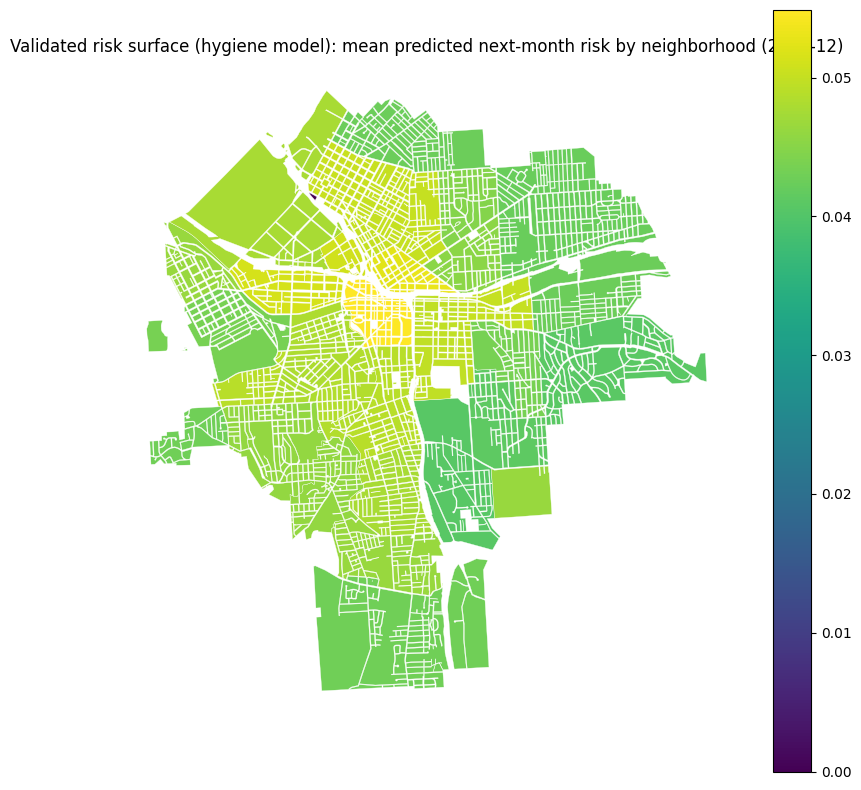

Saved: /content/drive/MyDrive/t3_data/outputs/visualizations/fig_pred_risk_map_validated_2024_12_hygiene.png


In [ ]:
panel_m = pd.read_parquet(PROCESSED_DIR / "panel_parcel_month_fullfeatures.parquet")
panel_m["month"] = pd.to_datetime(panel_m["month"])
panel_m["year"] = panel_m["month"].dt.year
panel_m["month_of_year"] = panel_m["month"].dt.month
panel_m = panel_m[(panel_m["month"] >= "2023-01-01") & (panel_m["month"] <= "2024-12-01")].copy()

TARGET = "y_next_1m"
panel_m[TARGET] = panel_m[TARGET].astype(int)

# -----------------------------
# Build features + hygiene drop
# -----------------------------
drop_cols = {"sbl", "month", "y_next_1m", "y_next_3m", "last_case_month"}
feature_cols = [c for c in panel_m.columns if c not in drop_cols]

num_cols = panel_m[feature_cols].select_dtypes(include=["number", "bool"]).columns.tolist()
cat_candidates = panel_m[feature_cols].select_dtypes(include=["object", "string"]).columns.tolist()

cat_cols = []
for c in cat_candidates:
    nunq = panel_m[c].nunique(dropna=True)
    if 2 <= nunq <= 100:
        cat_cols.append(c)

for c in ["year", "month_of_year"]:
    if c not in num_cols:
        num_cols.append(c)

X_cols = num_cols + cat_cols

def is_id_like(name: str) -> bool:
    n = name.lower()
    if n.startswith("objectid"): return True
    if n in {"shape_area","shape_length","shape__area","shape__length","tax_id","parcel_id","fid"}: return True
    if "_id" in n or "globalid" in n or "guid" in n: return True
    return False

X_cols = [c for c in X_cols if not is_id_like(c)]
cat_cols = [c for c in cat_cols if c in X_cols]

for c in cat_cols:
    panel_m[c] = panel_m[c].astype("category")

# -----------------------------
# Train-on-past, validate-on-2024-12
# -----------------------------
VAL_MONTH = pd.Timestamp("2024-12-01")

train_df = panel_m[panel_m["month"] < VAL_MONTH].copy()
val_df   = panel_m[panel_m["month"] == VAL_MONTH].copy()

print("Train rows:", len(train_df), "Val rows:", len(val_df), "Val pos rate:", round(val_df[TARGET].mean()*100, 3), "%")

X_train = train_df[X_cols]
y_train = train_df[TARGET].values
X_val   = val_df[X_cols]
y_val   = val_df[TARGET].values

pos_rate = float(y_train.mean())
scale_pos_weight = (1 - pos_rate) / max(pos_rate, 1e-6)

model = lgb.LGBMClassifier(
    n_estimators=4000,
    learning_rate=0.03,
    num_leaves=64,
    min_child_samples=50,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=SEED,
    n_jobs=-1,
    scale_pos_weight=scale_pos_weight
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric="auc",
    callbacks=[lgb.early_stopping(stopping_rounds=200, verbose=False)]
)

p = model.predict_proba(X_val)[:, 1]
ap = average_precision_score(y_val, p)
print("Validated PR-AUC for 2024-12 fold:", round(ap, 4))

val_pred = val_df[["sbl", "month", "nhood"]].copy()
val_pred["y_true"] = y_val
val_pred["y_score"] = p

# -----------------------------
# Aggregate to neighborhood risk + map
# -----------------------------
nhood_risk = (val_pred.groupby("nhood")
              .agg(mean_risk=("y_score", "mean"),
                   actual_rate=("y_true", "mean"),
                   n=("y_true", "size"))
              .reset_index()
              .sort_values("mean_risk", ascending=False))

out_tab = OUT_TAB_DIR / "nhood_risk_validated_2024_12_hygiene.csv"
nhood_risk.to_csv(out_tab, index=False)
print("Saved:", out_tab)
display(nhood_risk.head(10))

nhood_poly = gpd.read_file(PROCESSED_DIR / "nhood_polygons.gpkg").to_crs(epsg=4326)
gdf = nhood_poly.merge(nhood_risk, on="nhood", how="left")
gdf["mean_risk"] = gdf["mean_risk"].fillna(0)

ax = gdf.plot(column="mean_risk", legend=True, figsize=(8,8), edgecolor="white", linewidth=0.25)
ax.set_title(f"Validated risk surface (hygiene model): mean predicted next-month risk by neighborhood ({VAL_MONTH:%Y-%m})")
ax.set_axis_off()
plt.tight_layout()

out_fig = OUT_VIZ_DIR / "fig_pred_risk_map_validated_2024_12_hygiene.png"
plt.savefig(out_fig, dpi=200)
plt.show()

print("Saved:", out_fig)